# **ML Project - Forecasting products reorder based on Instacart data**
>**Karina Oborska**


## **Table of content**

1. Project Description
2. Import of Required Libraries
3. Data Sets Preparation
4. Preliminary Data Exploration and Cleaning
5. Feature Egineering
6. Exploratory Data Analysis
7. Training and evaluation of different models
8. Conclusions
9. Project Related Answers




## **Project Description**

**Task description**

The problem being addressed is predicting product reorders in the Instacart Market Basket Analysis dataset (https://www.kaggle.com/competitions/instacart-market-basket-analysis). This dataset includes user purchasing behavior, detailing the products bought, the orders placed, and the frequency of reordering. The ability to predict when a product will be reordered allows businesses to optimize their inventory management and stock levels, ensuring products are available to customers when needed.

**Key challenges in this project include:**

* Sequence data, that makes important considering temporal dependencies.
* Risk of data leakage due to sequential character of data it's important to avoid using future data to predict past events.
* Large amount of data, which increase the computational complexity and time required for model training.
* Multiclass classification and imbalanced data add another layer of complexity.

**Objective**

The goal of this machine learning project is to build a Reorder Prediction Model that accurately forecasts whether a customer will reorder a product in next order.

Steps include:
* Data preprocessing to clean the dataset, handle missing values, and prepare features.
* Exploratory data analysis (EDA) to visualize and understand patterns in user purchase behaviors.
* Model development using various techniques and included different algorithms.
* Model evaluation and comparison using performance metrics such as F1-score to ensure reliable predictions.

## **Import of Requierd Libraries**

In [2]:
%pip install category_encoders
%pip install catboost
%pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 3.3 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_recall_curve, make_scorer, f1_score
from category_encoders import JamesSteinEncoder, OneHotEncoder, TargetEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Embedding, GRU, Masking, TimeDistributed
from tensorflow.keras.metrics import CategoricalAccuracy

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# jupyter notebook directory
os.chdir('/Users/Karina/data_science/ds_weclouddata')

In [6]:
# google drive directory
os.chdir('/content/drive/My Drive/data_science')

In [7]:
# setting up the display of all columns
pd.set_option('display.max_columns', None)

## **Data Sets Preparation**

### **Datasets Summary based on below explorations:**
* aisles:  
columns: aisle_id, aisle **134 recordes**  
* department:  
columns: department_id, department **21 records**  
* products:  
columns: product_id, product_name, aisle_id, department_id **49 688 records**  
* orders:  
columns: order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order **3 421 083 records**  
* order_products_prior:  
columns: order_id, product_id, add_to cart_order, reordered **32 434 489 records**  
* order_products_train:  
columns: order_id, product_id, add_to cart_order, reordered **1 384 617 records**  

In [ ]:
# on kaggle there are 6 files available
aisles = pd.read_csv('./instacart-market-basket-analysis/aisles.csv')
departments = pd.read_csv('./instacart-market-basket-analysis/departments.csv')
order_products_prior = pd.read_csv('./instacart-market-basket-analysis/order_products__prior.csv')
order_products_train = pd.read_csv('./instacart-market-basket-analysis/order_products__train.csv')
orders = pd.read_csv('./instacart-market-basket-analysis/orders.csv')
products = pd.read_csv('./instacart-market-basket-analysis/products.csv')

In [ ]:
# joining tables: products, aisles and departments
full_products = pd.merge(products, aisles, on = 'aisle_id', how = 'left')
full_products = pd.merge(full_products, departments, on = 'department_id', how = 'left')

In [ ]:
# joining orders_prior with full_products
full_order_products_prior = pd.merge(order_products_prior, full_products, on = 'product_id', how = 'left')
# joining orders_train with full_products
full_order_products_train = pd.merge(order_products_train, full_products, on = 'product_id', how = 'left')

In [ ]:
# joining all data sets for having complete data for previous orders and save them to csv
order_prior_full = pd.merge(full_order_products_prior, orders[orders['eval_set'] == 'prior'], on ='order_id', how = 'left')

order_prior_full.to_parquet('order_prior_full.parquet', index = False)

In [ ]:
order_prior = pd.read_parquet('order_prior_full.parquet')

In [ ]:
# joining all data sets for having complete data for train orders
order_train_full = pd.merge(full_order_products_train, orders[orders['eval_set'] == 'train'], on ='order_id', how = 'left')

order_train_full.to_parquet('order_train_full.parquet', index = False)

In [ ]:
order_train = pd.read_parquet('order_train_full.parquet')


In [ ]:
# checking users in both prior and train sets and evaluating how many of them are common for both sets
users_prior = set(order_prior['user_id'])
print('Number of unique users in prior set:', len(users_prior))
users_train = set(order_train['user_id'])
print('Number of unique users in train set:', len(users_train))

common_users = users_prior.intersection(users_train)
print('Number of common users:', len(common_users))

Number of unique users in prior set: 206209
Number of unique users in train set: 131209
Number of common users: 131209


In [ ]:
# checking if the left 75000 users in the prior set are in the test set
orders = pd.read_csv('./instacart-market-basket-analysis/orders.csv')
orders.head()

users_test = (orders[orders['eval_set'] == 'test']['user_id'])

common_users_test = users_prior.intersection(users_test)
print('Number of common users:', len(common_users_test))

Number of common users: 75000


In [ ]:
# creating new order_prior_fin data set with only common users with orders_train set
order_prior_fin = order_prior[order_prior['user_id'].isin(common_users)]

In [ ]:
# checking if the orders in order_prior_fin are before the orders in order_train
order_prior_fin_max = order_prior_fin.groupby('user_id')['order_number'].max()
order_train_min = order_train.groupby('user_id')['order_number'].min()

(order_prior_fin_max < order_train_min).value_counts()

order_number
True    131209
Name: count, dtype: int64

Conclusions about datasets and users:
* The orders_prior dataset has 131209 users in common with orders_train dataset.
* Additionally, there are 75,000 users in orders_prior that are present in the test dataset.
* Because the test dataset lacks labels for the reordered products, I decided to exclude the users from the test dataset and focus only on the common users present in both orders_prior and orders_train for this project.
* I confirmed that the order_prior_fin dataset, which includes only users common with the order_train dataset, contains previous orders for the same clients as in order_train. Therefore, I have decided to use order_prior_fin as the training data and order_train as the testing data for this project.

In [ ]:
order_prior_fin.to_parquet('order_prior_fin.parquet', index = False)

In [8]:
df_train = pd.read_parquet('./order_prior_fin.parquet')
df_test = pd.read_parquet('./order_train_full.parquet')

## **Preliminary Data Exploration and Cleaning**

**Summary of datasets:**  
* df_train: 20 641 991 records  
* df_test: 1 384 617 records  
* Both have same 15 columns: 'order_id', 'product_id', 'add_to_cart_order', 'reordered', 'product_name', 'aisle_id', 'department_id', 'aisle', 'department', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'

First I am going to analyse df_train and create some features which at the end I also implement on df_test

In [10]:
df_train.head(5)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20641991 entries, 0 to 20641990
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   add_to_cart_order       int64  
 3   reordered               int64  
 4   product_name            object 
 5   aisle_id                int64  
 6   department_id           int64  
 7   aisle                   object 
 8   department              object 
 9   user_id                 int64  
 10  eval_set                object 
 11  order_number            int64  
 12  order_dow               int64  
 13  order_hour_of_day       int64  
 14  days_since_prior_order  float64
dtypes: float64(1), int64(10), object(4)
memory usage: 2.3+ GB


* Categorical variables: reordered, product_name, aisle, department, order_dow, order_hour_of_day  
* Numerical variables: add_to_cart_order, days_since_prior_order
* Other organizational variables: order_id, product_id, department_id, aisle_id, eval_set, order_number

In [ ]:
# checking if there are missing values
print(f'Number of missing values in dataset \n{df_train.isna().sum()}')

Number of missing values in dataset 
order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    1322352
dtype: int64


In [ ]:
# checking if all orders which had NaN value were the first one for the particular client
df_train[df_train['days_since_prior_order'].isna()]['order_number'].unique()

array([1])

In [ ]:
# filling NaN values with 0 which means there was no days since prior order as that was the first order from the client
df_train.fillna({'days_since_prior_order' : 0}, inplace = True)

In [ ]:
# checking if there are any duplicates in dataset
print(f'Number of duplicated values in dataset: {df_train.duplicated().sum()}')

Number of duplicated values in dataset: 0


In [ ]:
# checking number of unique values in each column
for column in df_train.columns:
    number = df_train[column].nunique()
    print(f'There are {number} {column}')

There are 2047377 order_id
There are 49468 product_id
There are 145 add_to_cart_order
There are 2 reordered
There are 49468 product_name
There are 134 aisle_id
There are 21 department_id
There are 134 aisle
There are 21 department
There are 131209 user_id
There are 1 eval_set
There are 99 order_number
There are 7 order_dow
There are 24 order_hour_of_day
There are 31 days_since_prior_order


In [ ]:
df_train.describe()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,2.064199e+07,2.064199e+07,2.064199e+07,2.064199e+07,2.064199e+07,2.064199e+07,2.064199e+07,2.064199e+07,2.064199e+07,2.064199e+07,2.064199e+07
mean,1.710944e+06,2.557423e+04,8.340616e+00,5.894456e-01,7.123580e+01,9.920194e+00,1.028193e+05,1.713118e+01,2.739519e+00,1.342526e+01,1.039192e+01
std,9.869931e+05,1.409768e+04,7.117828e+00,4.919344e-01,3.820153e+01,6.280300e+00,5.948499e+04,1.750205e+01,2.091324e+00,4.250882e+00,8.918339e+00
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.568900e+05,1.353500e+04,3.000000e+00,0.000000e+00,3.100000e+01,4.000000e+00,5.142300e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.711408e+06,2.525600e+04,6.000000e+00,1.000000e+00,8.300000e+01,9.000000e+00,1.023550e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.564972e+06,3.792300e+04,1.100000e+01,1.000000e+00,1.070000e+02,1.600000e+01,1.544650e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.400000e+01
max,3.421082e+06,4.968800e+04,1.450000e+02,1.000000e+00,1.340000e+02,2.100000e+01,2.062090e+05,9.900000e+01,6.000000e+00,2.300000e+01,3.000000e+01


* Average number of products added to the basket is  around 8. However, there are cases with significantly more products, with maximum of 145 products in a single order.
* Most orders are placed midweek, with a slight concentration around Tuesday and Wednesday. The average order hour is around 13:00.
* The average number of days since the prior order is approximately 11, but there are notable peaks and outliers. Some customers reorder after very short periods (a few days), while others wait up to 30 days, indicating potential regular shopping patterns like weekly or monthly cycles.

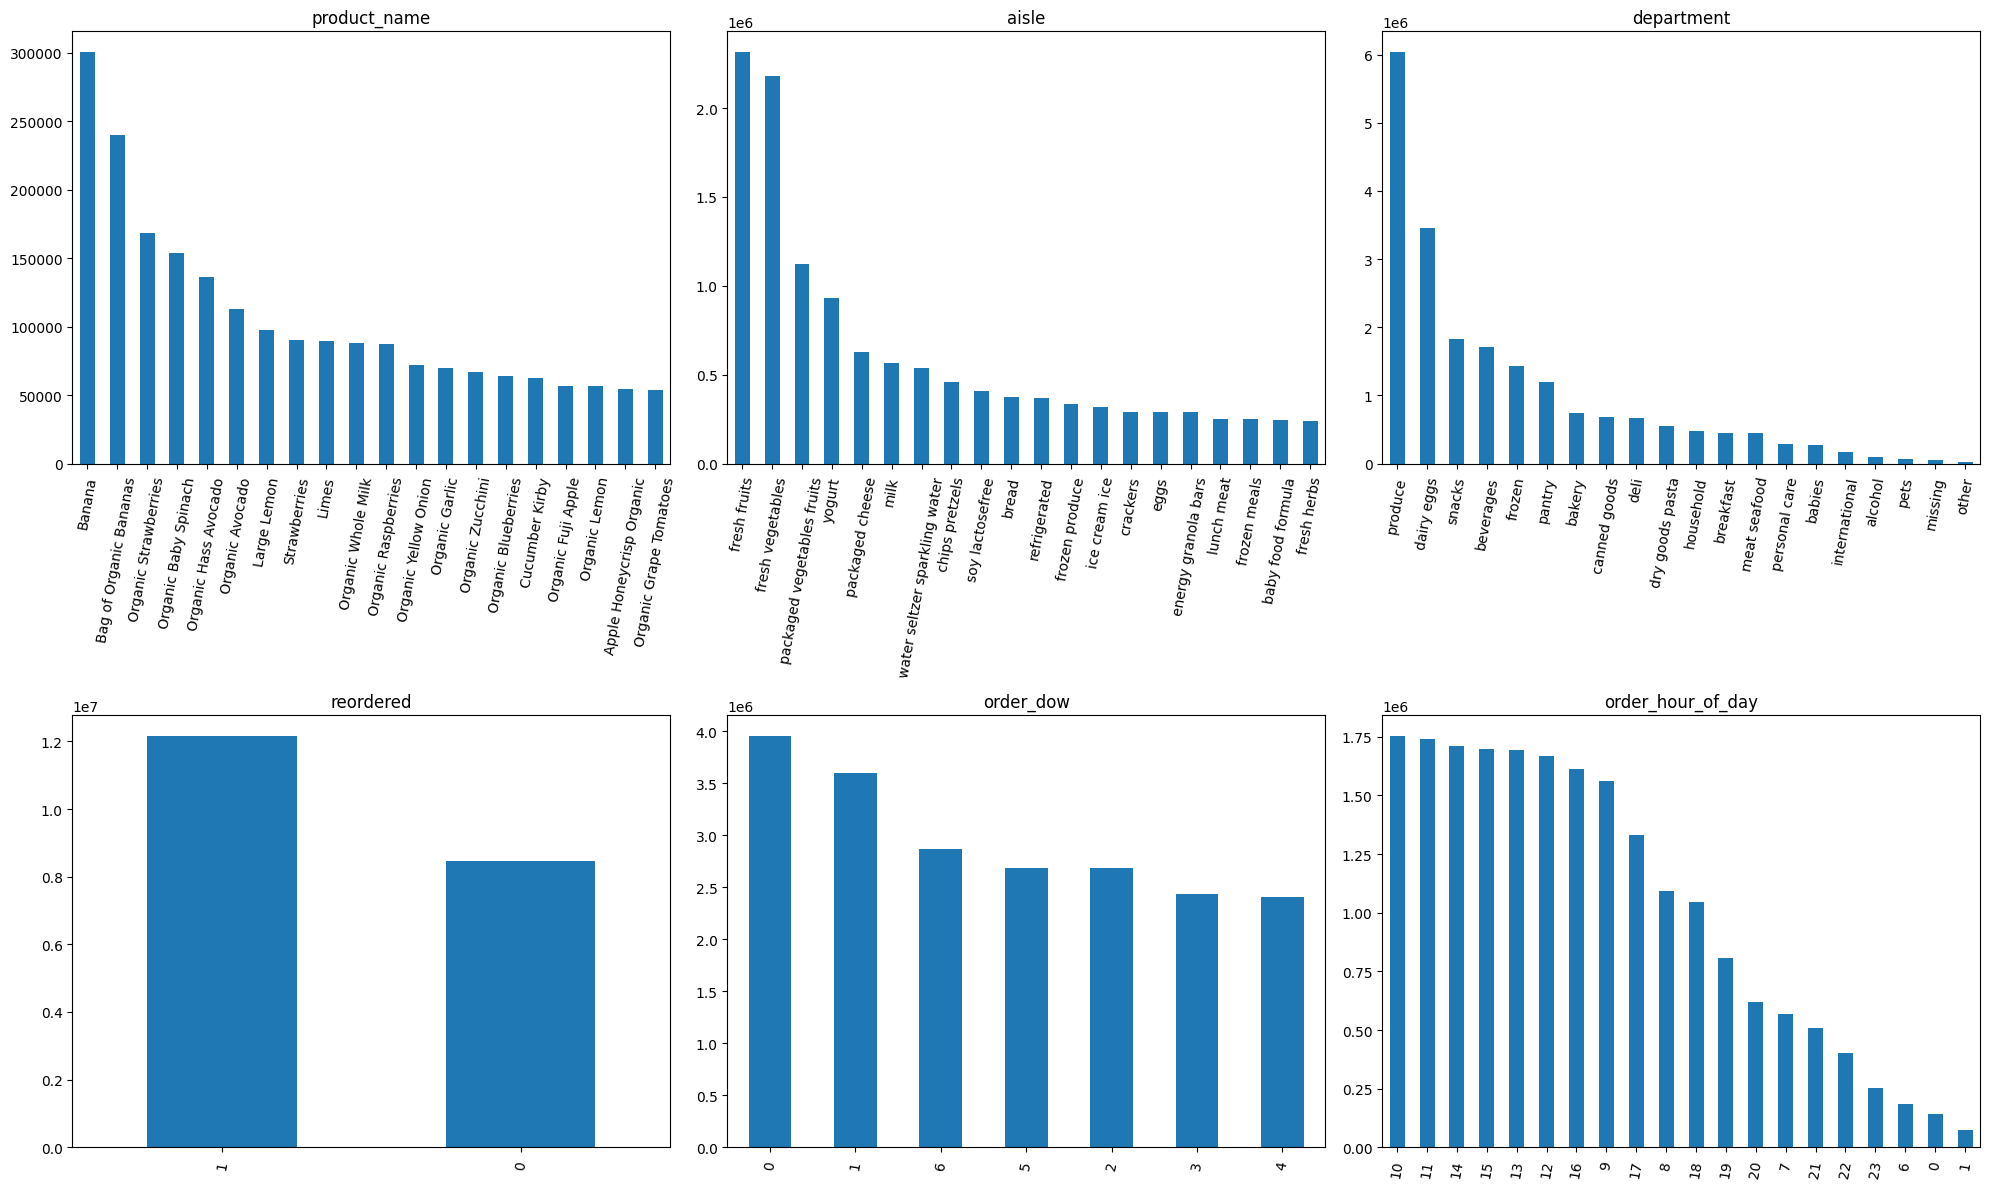

In [ ]:
# checking the distribution of categorical variables; for aisles and products only top 20 due to high number of unique values
categorical_columns = ['product_name', 'aisle', 'department', 'reordered', 'order_dow', 'order_hour_of_day']

fig, axes = plt.subplots(2, 3, figsize = (20, 12))

for i, column in enumerate(categorical_columns):
    row = i // 3
    col = i % 3
    df_train[column].value_counts().nlargest(20).plot(kind = 'bar', ax = axes[row, col])
    axes[row, col].set_title(column)
    axes[row, col].tick_params(axis = 'x', rotation = 80, labelsize = 10)
    axes[row, col].xaxis.set_tick_params(pad=5)
    axes[row, col].set_xlabel('')

plt.tight_layout()
plt.show()

* The most frequent orders are placed on Sunday and Monday. Orders are mainly placed in the first half of the day, with a peak between 10:00 and 14:00.
* Fruits, vegetables, and organic products are the most commonly chosen items, indicating a preference for healthy food options. Bananas are the most frequently purchased item.
* In terms of aisles, the most popular are “fresh fruits” and “fresh vegetables”, and the largest department is produce, followed by dairy and eggs.
* More products are reordered than ordered just once, suggesting that customers frequently return to repurchase items they’ve bought before, indicating strong product loyalty and habit formation.

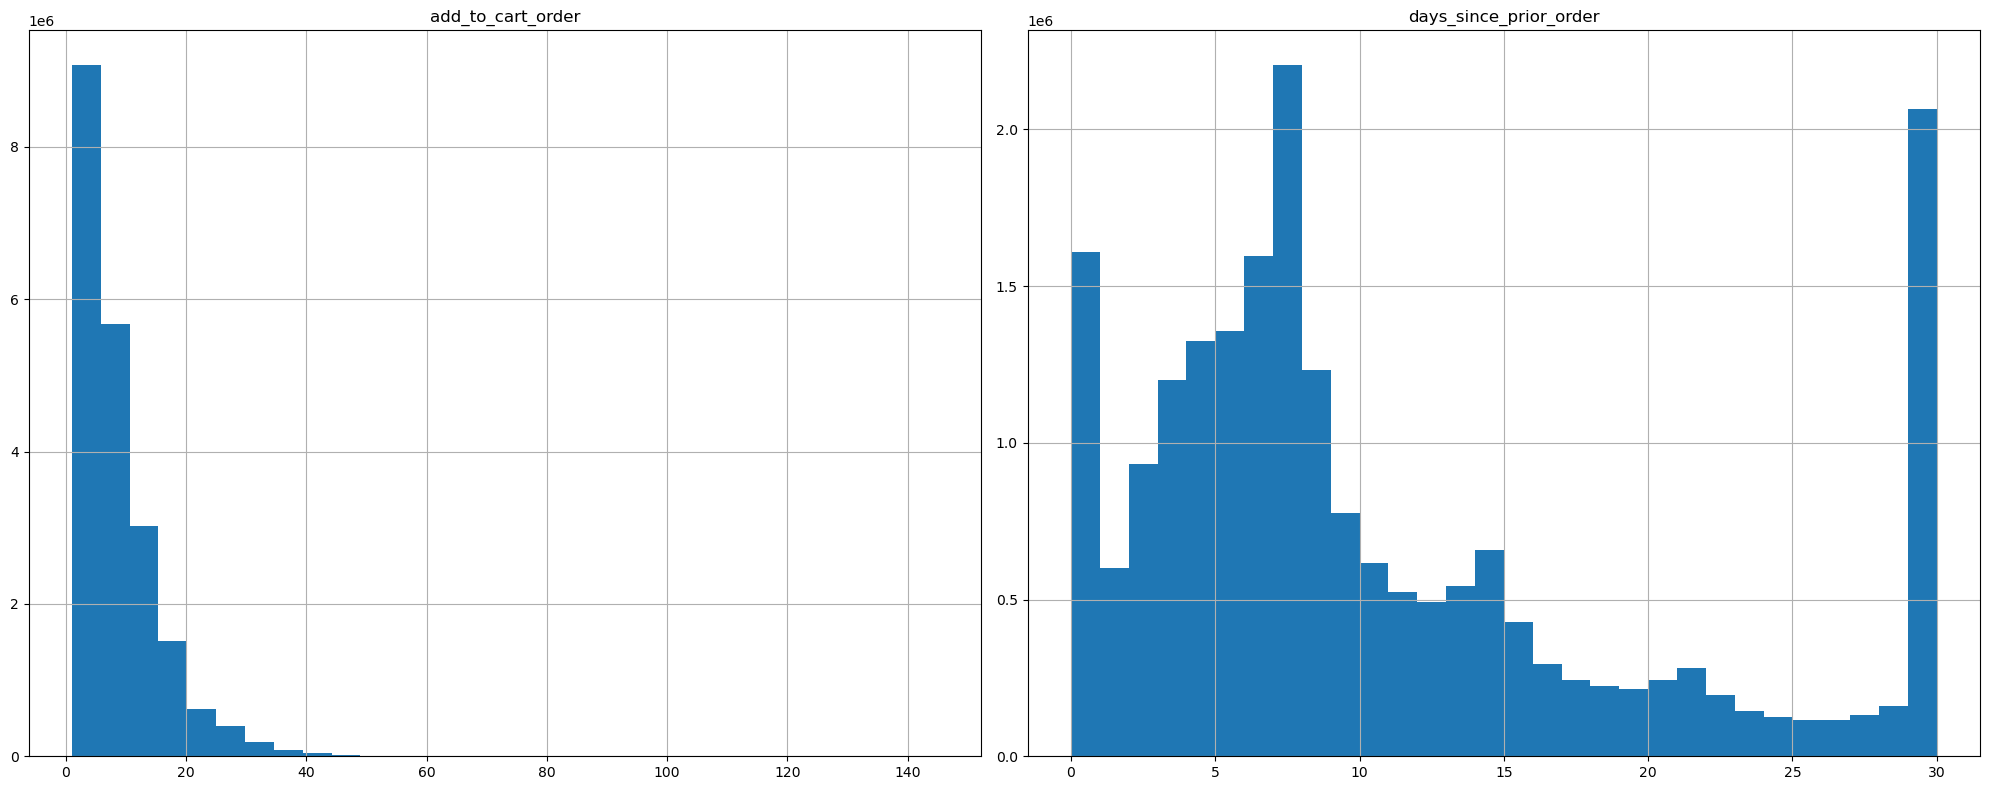

In [ ]:
# checking the distribution of numerical variables

numerical_columns = ['add_to_cart_order', 'days_since_prior_order']

df_train[numerical_columns].hist(bins = 30, figsize = (20, 8))
plt.tight_layout()
plt.show()

* The most orders include less than 20 products. The distribution is right-skewed, that means there appeared orders with products number higher than 140. Maybe this is connected with wholesale. It can be considered to get rid of outliers - for further research.
* Anaother anomaly to check is high number of orders with 0 days in between - it's worth to check if these are all orders placed as a first or there are clients who place all orders same day
* Days since prior order are more eqully distibuted, however there are two visible peaks at around 7 days and at 30 days, that can show some cycles - regular shopping once for a week or once for a month.

In [ ]:
# checking the level of 99 percentile

percentile = np.percentile(df_train['add_to_cart_order'], 99.99)

print(f'99.99 percentile of add_to_cart_order: {percentile}')

99.99 percentile of add_to_cart_order: 71.0


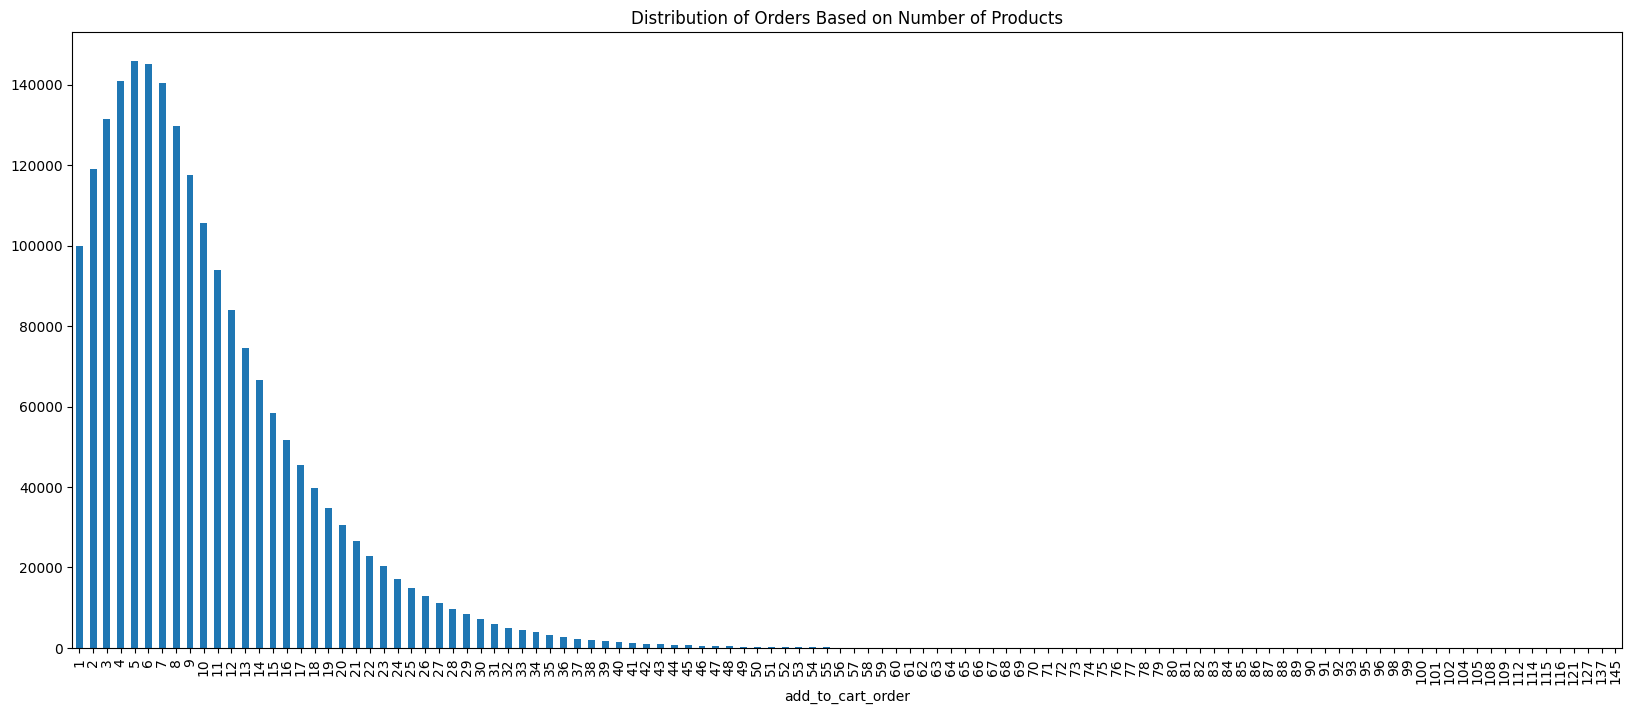

In [ ]:
# plotting orders based on the number of products they include
df_train.groupby('order_id')['add_to_cart_order'].max().value_counts().sort_index().plot(kind = 'bar', figsize = (20, 8))
plt.title('Distribution of Orders Based on Number of Products', fontsize=12)
plt.show()

* 99.99 percentile is at the very low number - 70, that means that most orders have lower number of products
* it looks like orders with more than 70-80 products are more unique and rare -> it's worth to check if they were made by clients who placed just one order or they are a part of some regular shoppings

In [ ]:
# checking clients who placed orders with more than selected level of products
num_products = df_train.groupby(['order_id', 'user_id'])['add_to_cart_order'].max()
filtered_user_ids = num_products[num_products > 105].index.get_level_values('user_id').unique()

filtered_user_ids

Index([22906, 25070, 129928, 49110, 79738], dtype='int64', name='user_id')

In [ ]:
filtered_df = df_train[df_train['user_id'].isin(filtered_user_ids)]

In [ ]:
# checking statitics like min, max, std, count, mean, median of all orders belong to users who made at least one order with higher number of products than 105
selected_users = filtered_df.groupby(['user_id', 'order_id'])['add_to_cart_order'].max().sort_values(ascending = False)

selected_users_df = selected_users.reset_index()
selected_users_df.columns = ['user_id', 'order_id', 'number_ord']

selected_users_df.groupby('user_id')['number_ord'].agg(['min', 'max', 'std', 'count', 'mean', 'median'])

,min,max,std,count,mean,median
user_id,,,,,,
22906,1,145,38.266467,22,38.681818,24.5
25070,1,109,27.288505,16,31.562500,26.5
49110,13,114,32.390447,13,49.846154,43.0
79738,4,121,31.315531,16,26.562500,11.5
129928,1,137,32.094216,64,56.843750,54.5


* After analyzing the statistics of customers with high product count orders, I have decided not to delete these orders, as they come from regular clients with varied purchasing patterns. This suggests that such large orders are part of their typical behavior rather than outliers.
* In some cases, the mean and median are quite close (e.g., user_id 25070 and user_id 22906), indicating that the distribution of the number of products in their orders is approximately normal. However, there are also cases where the mean is higher than the median (e.g., user_id 49110 and user_id 129928), which suggests a right-skewed distribution — these clients place occasional large orders that increase the average number of products.
* The standard deviation for most users is relatively high, especially for users with maximum order sizes exceeding 100 products, indicating a wide variability in their order sizes. This variability is an important feature that may help to understand different client segments and purchasing patterns.

### Analysing clients, who placed all their orders in one day

In [ ]:
# separating the data for clients who made all orders same day

no_break_between_orders = df_train.groupby('user_id')['days_since_prior_order'].apply(lambda x: (x == 0).all())

clients_all_orders_same_day = no_break_between_orders[no_break_between_orders == True].index

# checking what is the number of records and users who placed all their orders same day
users = df_train[df_train['user_id'].isin(clients_all_orders_same_day)]['user_id'].nunique()
records = df_train[df_train['user_id'].isin(clients_all_orders_same_day)]['product_id'].count()

print(f'There is {users} users and {records} records for clients who makes all orders on the same day')

There is 16 users and 199 records for clients who makes all orders on the same day


In [ ]:
#checking descrapencies between typical clients and clients who placed all orders same day

typical_users = df_train[~df_train['user_id'].isin(clients_all_orders_same_day)]
outlier_users = df_train[df_train['user_id'].isin(clients_all_orders_same_day)]

print("Average number of orders for typical clients:", typical_users.groupby('user_id')['order_id'].nunique().mean())
print("Average number of orders for clients placing many orders same day:", outlier_users.groupby('user_id')['order_id'].nunique().mean())
print()
print("Average number of products for typical clients:", typical_users.groupby('user_id')['product_id'].count().mean())
print("Average number of products for clients placing many orders same day:", outlier_users.groupby('user_id')['product_id'].count().mean())
print()
print("Ratio of clients placing orders same day vs. typical clients:", round(outlier_users['user_id'].nunique()/typical_users['user_id'].nunique(), 4))


Average number of orders for typical clients: 15.605405776222817
Average number of orders for clients placing many orders same day: 3.5625

Average number of products for typical clients: 157.33912632533747
Average number of products for clients placing many orders same day: 12.4375

Ratio of clients placing orders same day vs. typical clients: 0.0001


* We can see that clients who placed all their orders on the same day make up a very small part of the data compared to typical clients.
* There are also big differences in basic stats, like the average number of orders and products, between these two groups.
* In my opinion, the best approach is to remove these outliers, as they don’t have much impact on the data. Keeping them could disrupt further calculations, and it’s also unclear if these patterns reflect real buying habits – maybe the data for these clients is incomplete, especially in terms of days between orders.

In [ ]:
# deleting clients who placed all orders same day

df_train = df_train[~df_train['user_id'].isin(clients_all_orders_same_day)]

### Analysing orders which consist only of products not reordered

In [ ]:
# selecting orders with only not reordered products
orders_products_no_reordered = df_train.groupby('order_id')['reordered'].apply(lambda x: (x == 0).all())

orders_products_no_reordered = orders_products_no_reordered[orders_products_no_reordered == True].index

In [ ]:
# checking if these orders are only the first orders for clients and if not what are the quantities of these orders
check_orders_all_not_reordered = df_train[df_train['order_id'].isin(orders_products_no_reordered)]

first_orders = check_orders_all_not_reordered[check_orders_all_not_reordered['order_number'] == 1]['order_id'].nunique()
first_percent = round(first_orders/df_train['order_id'].nunique()*100, 2)
print(f'There are {first_orders} orders which are first orders and include only products not reordered, that is {first_percent}% of all orders')

not_first_orders = check_orders_all_not_reordered[check_orders_all_not_reordered['order_number'] != 1]['order_id'].nunique()
rest_percent = round(not_first_orders/df_train['order_id'].nunique()*100, 2)
print(f'There are {not_first_orders} orders which are not first orders and include only products not reordered, that is {rest_percent}% of all orders')


There are 131193 orders which are first orders and include only products not reordered, that is 6.41% of all orders
There are 115815 orders which are not first orders and include only products not reordered, that is 5.66% of all orders


* First-time placed orders will get separate label 2, as they often include products that may be reordered in future orders. This adjustment is important because including first-time products as reordered could distort the analysis, especially when examining correlations between features and the target variable, as we would lack prior history for these products.
* For other orders that include products which have not been reordered before but are not first-time orders, also set the reordered value to label 2. This is because, for these products, I don't have prior purchase history, and including them as reordered could disturb the modeling process, as it would introduce noise and mislead predictions based on historical patterns.

In [ ]:
# according to the results above, all orders which consist only of not reordered products will have reordered column set to 2

df_train.loc[df_train['order_id'].isin(orders_products_no_reordered), 'reordered'] = 2

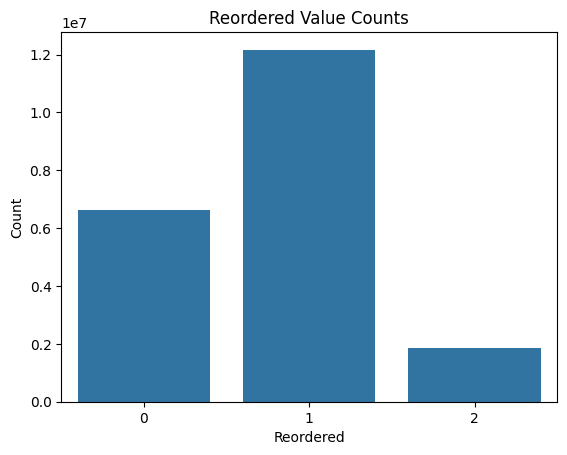

In [ ]:
# checking quantity of reordered and not reordered products
value_counts_reordered = df_train['reordered'].value_counts(dropna = False)

sns.barplot(x=value_counts_reordered.index, y=value_counts_reordered.values)

plt.title('Reordered Value Counts')
plt.xlabel('Reordered')
plt.ylabel('Count')

plt.show()

After assigning label 2 to orders with only non-reordered products, I now have an imbalanced target variable, which needs to be considered during the modeling process. Using balancing methods will be challenging due to the sequential nature of the data.

### Distribution of variables based on the target

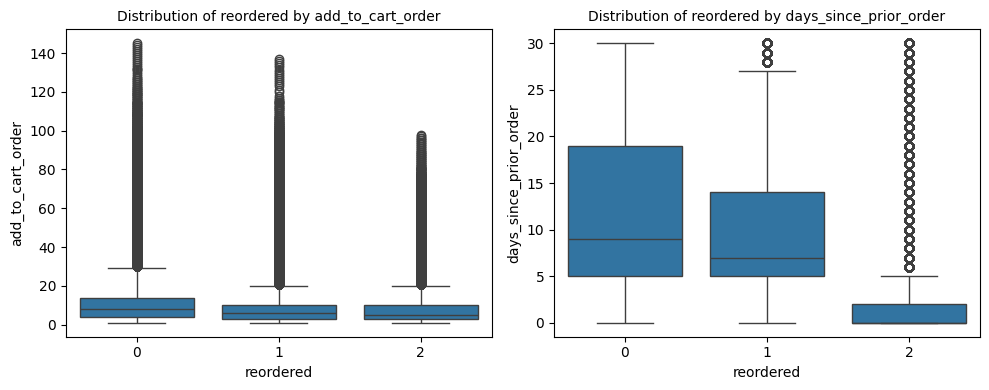

In [ ]:
# numerical variables
numerical_columns = ['add_to_cart_order', 'days_since_prior_order']

fig, axes = plt.subplots(1, 2, figsize = (10, 4))

for i, column in enumerate(numerical_columns):
    sns.boxplot(x = df_train['reordered'], y = df_train[column],  ax = axes[i])
    axes[i].set_title(f'Distribution of reordered by {column}', fontsize=10)

plt.tight_layout()
plt.show()

* Most reordered products are added to the cart within the first 10 positions. Even appear in orders with extreme numbers of products (up to 140 items), these are placed by returning customers.
* Non-reordered products show a higher level of outliers. These products might be added toward the end of a shopping session, potentially indicating that they are less essential or impulse purchases made only once.
* Products that are not reordered are more often added at later positions, which is consistent with the above conclusion.
* Products ordered for the first time have similar characteristics to reordered products, but with a lower level of outliers up to the 100th position.
* When examining days since prior order, the range is broader and possibly more random for non-reordered products, indicating a less consistent purchasing pattern.
* For reordered products, most are repurchased within a span of less than 14 days, with some notable exceptions where the gap extends to around 30 days, potentially pointing to regular monthly shopping cycles.
* Products ordered for the first time are placed in orders with a shorter break since the last purchase.

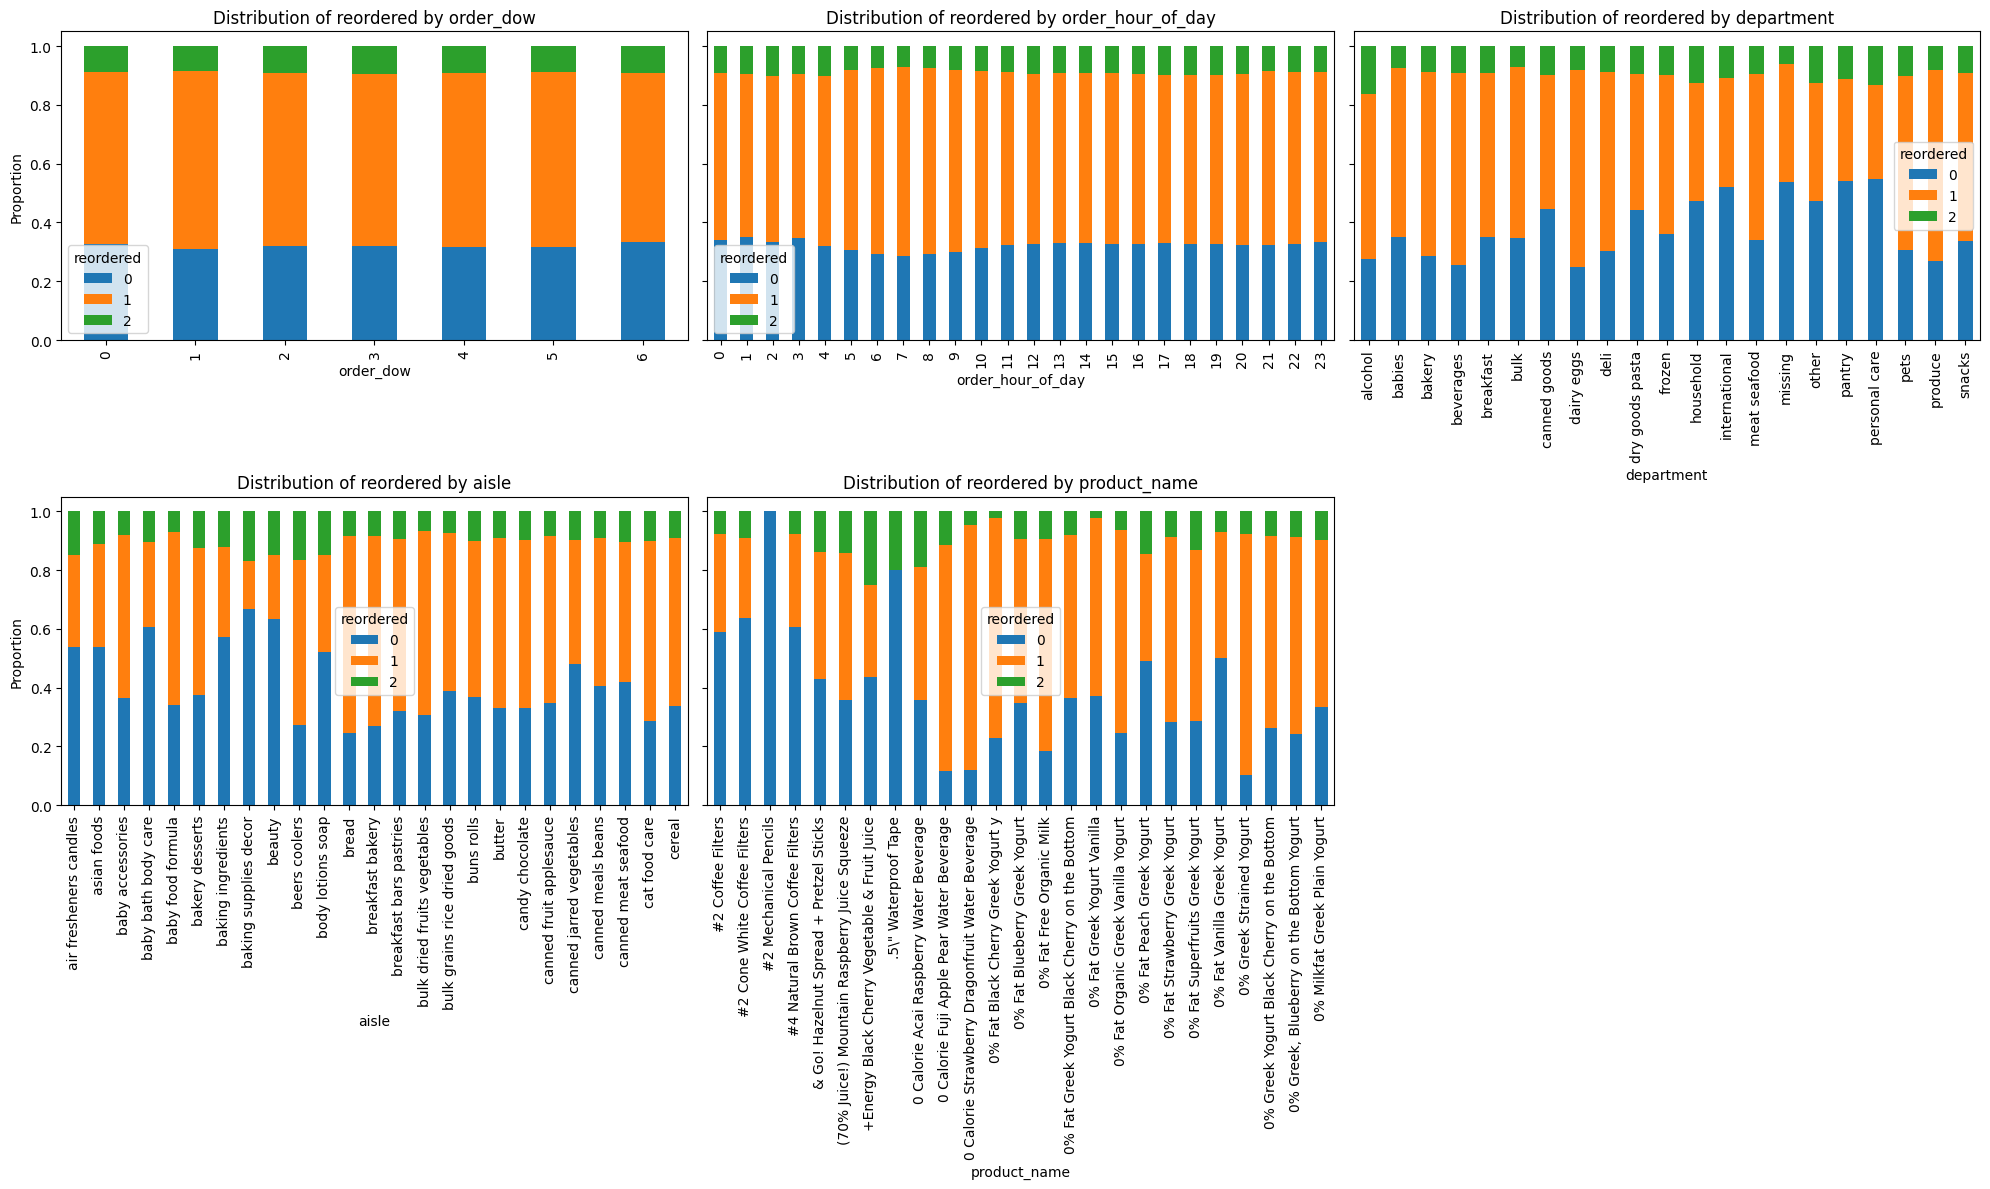

In [ ]:
# categorical variables
categorical_columns = ['order_dow', 'order_hour_of_day', 'department', 'aisle', 'product_name']

fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=True)

# flatten the 2D grid of axes into a 1D array so we can easily index each subplot
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    # creating table of frequency for each category and column
    grouped_data = df_train.groupby([column, 'reordered']).size().unstack(fill_value=0)

    # normalize the data so that the rows sum to 1 (proportions)
    normalized_data = grouped_data.div(grouped_data.sum(axis=1), axis=0)

    # limititing up to 25 first positions for aisle and product_name due to their high number of unique values
    if column in ['aisle', 'product_name']:
        normalized_data = normalized_data.head(25)

    normalized_data.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'Distribution of reordered by {column}')
    axes[i].set_ylabel('Proportion')
    axes[i].set_xlabel(column)

# Deleting space for last graph if there is lack of it
for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* There are no significant differences in reordering patterns based on the day of the week.
* Most reordered products are bought in the early morning like 6-8 o'clock.
* Strong correlations exist between the type of product, aisle, or department and the likelihood of reordering.

In [ ]:
# saving df after changes for further analysis
df_train.to_parquet('df_train.parquet', index = False)

In [ ]:
df_train = pd.read_parquet('./df_train.parquet')

## **Feature Engineering**

### Creating features for training (phase 1 after EDA)

Checking features connected with client's behaviour: how often he places the order, what is the size of it, how often he buys.

In [ ]:
def user_behaviour_features(df):

    '''
    Function to create new features based on user behaviour in the online store.
    Args: data frame
    Returns: data frame with new features
    '''

    # creating a copy of the DataFrame to avoid 'SettingWithCopyWarning' during modifications.
    df = df.copy()

    # help function to count average number of products per order
    def avg_num_products_per_order(x):
        return x.count()/x.nunique()

    # counting the 25th quantile  to use it as a treshold
    treshold_25 = df['add_to_cart_order'].quantile(0.25)

    operations = {

        # creating for each user a new column with the number of total orders
        'num_orders' : ('order_number', 'max'),

        # checking the average number of products per order for each user based on all client's orders
        'avg_num_products' : ('order_number', avg_num_products_per_order),

        # checking the average number of days between orders for each user based on all client's orders excluding first order with 0 days
        'avg_time_in_orders': ('days_since_prior_order', lambda x: x[x > 0].mean()),

        # creating the new variable indicates if the product was ordered at the beginning of the order
        'added_early': ('add_to_cart_order', lambda x: 1 if x <= treshold_25 else 0)
    }

    for new_col, (col, op) in operations.items():

        if new_col == 'added_early':
            df[new_col] = df['add_to_cart_order'].apply(op)
        else:
            df[new_col] = df.groupby('user_id')[col].transform(op)

    return df

Checking features connected with products, that set up rank to products, aisles and departments according to their popularity

In [ ]:
def rank_reordered(df, column_list):
    '''
    Function which ranks selected column based on the number of times their elements appeared in client's orders
    Args: dataframe, column list
    Returns: data frame with new columns
    '''

    # creating a copy of the DataFrame to avoid 'SettingWithCopyWarning'
    df = df.copy()

    for column in column_list:
        # Deleting '_id' from the column name
        clean_column_name = column.replace('_id', '')

        # Rankowanie na poziomie grupy bezpośrednio przez transform
        df[f'{clean_column_name}_rank'] = (
            df.groupby('user_id')[column]
            .transform(lambda x: x.map(x.value_counts().rank(method='dense', ascending=True)))
        )

    return df

Creating features connected with product usage: what is the time since last order of the product, average time between products orders or how many times product was reordered

In [ ]:
def cum_days(df):

    '''
    Function that creates a new column with cumulative days for orders for each user for further calculations
    Args: data frame
    Returns: data frame with a new column with cmulated days
    '''
    df = df.sort_values(by=['user_id', 'order_number'])

    # the aggregation of data is neccessary to get the cumulative days for each order
    cum_frame = df.groupby(['user_id', 'order_number', 'order_id'])['days_since_prior_order'].agg('max').groupby(level = 0).cumsum().fillna(0).reset_index()

    cum_frame.rename(columns = {'days_since_prior_order' : 'cum_days_since_prior_order'}, inplace = True)

    df['cum_days_since_prior_order'] = df['order_id'].map(cum_frame.set_index('order_id')['cum_days_since_prior_order'])

    return df

In [ ]:
def products_usage(df):

    '''
    Function to create new features based on usage of product.
    Args: data frame
    Returns: data frame with new features
    '''
    # creating a copy of the DataFrame to avoid 'SettingWithCopyWarning' during modifications.
    df = cum_days(df)

    df['cum_days_since_prior_order_prod'] = df['cum_days_since_prior_order']

    # filling the first order with 0 days since prior order to avoid cummulating with next orders
    df.loc[df.groupby(['user_id', 'product_id']).cumcount() == 0, 'cum_days_since_prior_order_prod'] = 0

    # grouping data frame to make it only once in further variable creation
    group = df.groupby(['user_id', 'product_id'])

    # sorting the data what is obligatory to count consecutive ordering and number of consective reorders
    df = df.sort_values(['user_id', 'product_id', 'order_number'])

    # creating the new variable which indicates the number of days since the last order of the product
    df.loc[:, 'days_last_prod_order'] = group['cum_days_since_prior_order_prod'].diff().fillna(0)
    df.loc[df['days_last_prod_order'] < 1, 'product_reordered_times'] = np.nan

    # creating the new variable with average number of days between orders for each product
    avg_days_between_prod_orders = df[(df['reordered'] == 1) & (df['days_last_prod_order'] > 0)].groupby(['user_id', 'product_id'])['days_last_prod_order'].mean().round(1)
    df['avg_days_between_prod_orders'] = df.set_index(['user_id','product_id']).index.map(avg_days_between_prod_orders).fillna(np.nan)

    # creating a variable which gives 1 when the product was bought consecutive and 0 if not
    df['consecutive'] = group['order_number'].diff().eq(1).astype(int)
    df.loc[df['reordered'] != 1, 'consecutive'] = 0

    # creating id for groups where product was bought consecutive - it is necessary to count number of consecutive orders of a product
    df['groupId'] = df['consecutive'].eq(0).cumsum()

    # counting the number of consecutive orders of a product
    df['consecutive_reorder'] = df.groupby(['user_id', 'product_id', 'groupId'])['consecutive'].cumsum()

    # counting how many times product were reordered by a client
    df['product_reordered_times'] = group['reordered'].transform(lambda x: (x == 1).sum())

    # checking ratio of reordered times to total number of orders to asses the popularity of product for particular client, assigning 0 to the first order when product was not ordered before
    df['ratio_product_reordered_times'] = round(df['product_reordered_times']/df['num_orders'], 2)

    # counting the average position of the product in the cart for each user
    df['user_prod_avg_pos_cart'] = group['add_to_cart_order'].transform('mean')

    # counting the maximum position of the product in the cart for each user
    df['user_prod_max_pos'] = group['add_to_cart_order'].transform('max')

    return df

Dividing training set for train and test before preparing features to avoid data leakage; in test set there is only one last order for each client.

In [ ]:
data_train = df_train[df_train['order_number'] != df_train.groupby('user_id')['order_number'].transform('max')]

In [ ]:
data_test = df_train[df_train['order_number'] == df_train.groupby('user_id')['order_number'].transform('max')]

In [ ]:
data_test.to_parquet('data_test.parquet', index = False)

In [ ]:
# checking share of all classes in both train and test sets
print(data_train['reordered'].value_counts(normalize = True) * 100)
print(data_test['reordered'].value_counts(normalize = True) * 100)
print(round(((data_test.shape[0]/(data_train.shape[0] + data_test.shape[0]))*100), 2))

reordered
1    58.965244
0    31.610263
2     9.424494
Name: proportion, dtype: float64
reordered
1    58.654928
0    38.296278
2     3.048794
Name: proportion, dtype: float64
6.58


Test data are only 6,6% of all data set, but this i sthe nature of the sequence problem.

In [ ]:
# creating features based on user behaviour for train set
ub_set = user_behaviour_features(data_train)

In [ ]:
# creating features based on product kind for train set
product_info = ['product_id', 'aisle', 'department']
pk_set = rank_reordered(ub_set, product_info)

In [ ]:
# creating features based on product usage for train set
train_set = products_usage(pk_set)

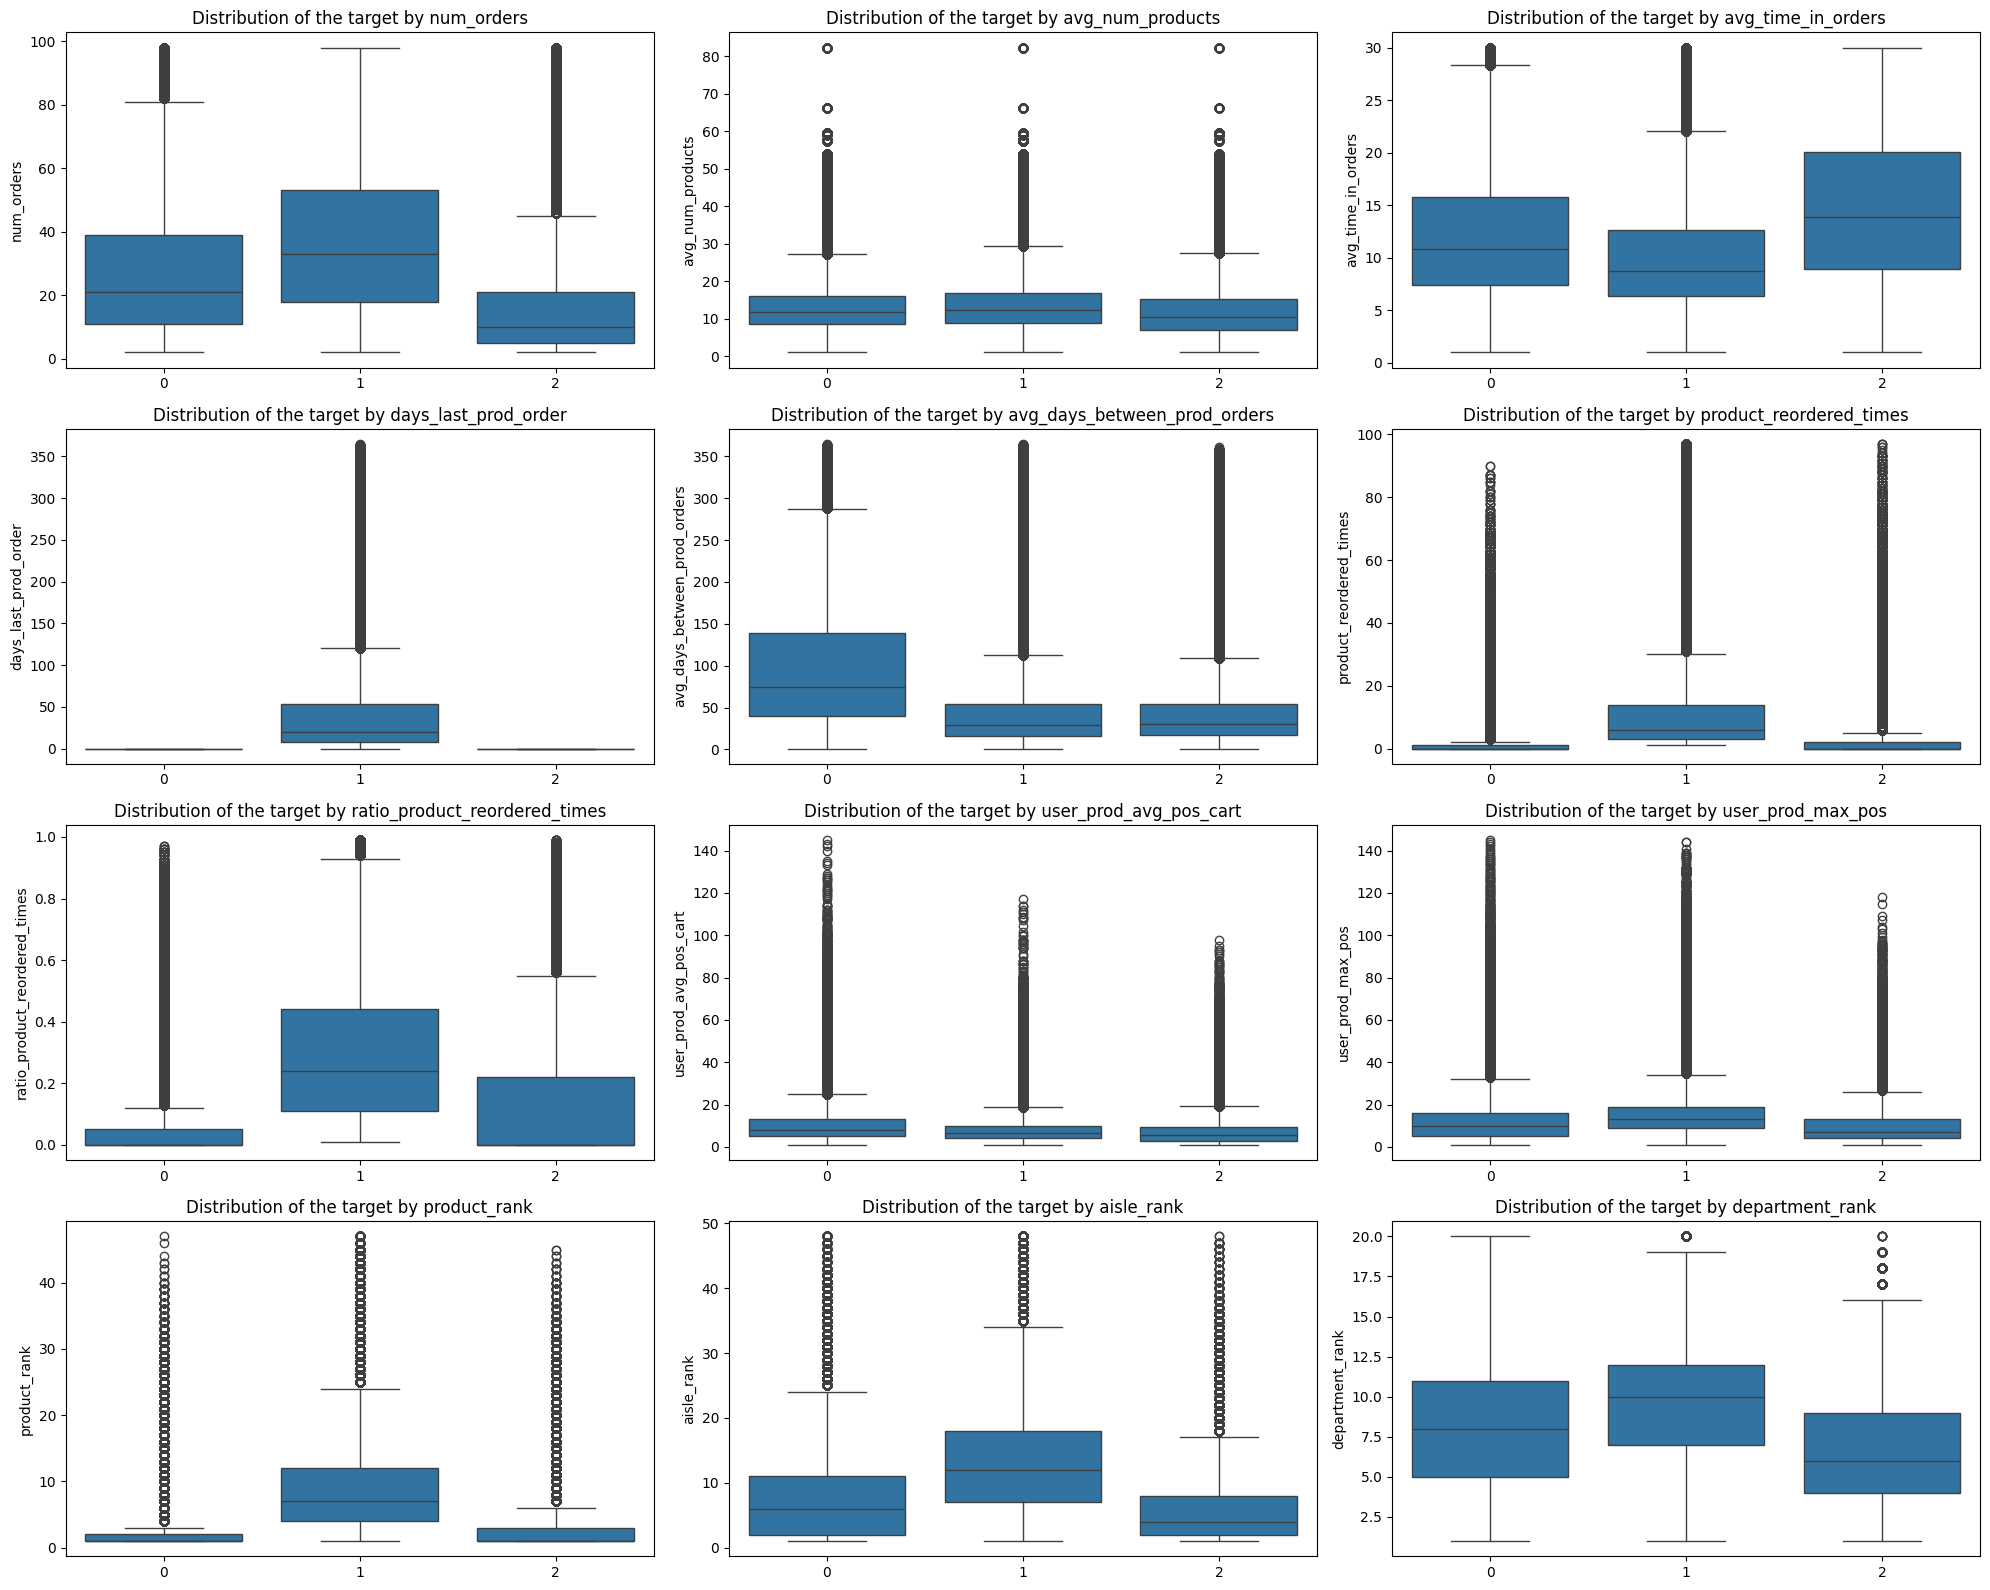

In [ ]:
# visualization of numerical features
col_num = ['num_orders', 'avg_num_products', 'avg_time_in_orders', 'days_last_prod_order', 'avg_days_between_prod_orders', 'product_reordered_times', 'ratio_product_reordered_times', 'user_prod_avg_pos_cart', 'user_prod_max_pos', 'product_rank', 'aisle_rank', 'department_rank']

fig, axes = plt.subplots(4, 3, figsize = (20, 16))

for i, column in enumerate(col_num):
    row = i // 3
    col = i % 3

    sns.boxplot(x = train_set['reordered'], y = train_set[column],  ax = axes[row, col])
    axes[row, col].set_title(f'Distribution of the target by {column}')
    axes[row, col].set_xlabel('')

plt.tight_layout()
plt.show()

1. Customers who order frequently are more likely to reorder, indicating that consistent customers prefer familiar products.
2. Popular products and those from frequently shopped aisles have higher reorder rates, suggesting that the particular type of product can have influence on purchase decision.
3. Products which are more likely reordered have shorter breaks in their purchase cycle.
4. Metrics such as the number of products per order and the interval since the last purchase effectively differentiate between reordered and not reordered classes, underlining their predictive value.
5. The clear distinction in distribution across different reorder statuses for key features suggests these variables are effective in distinguishing between the classes.


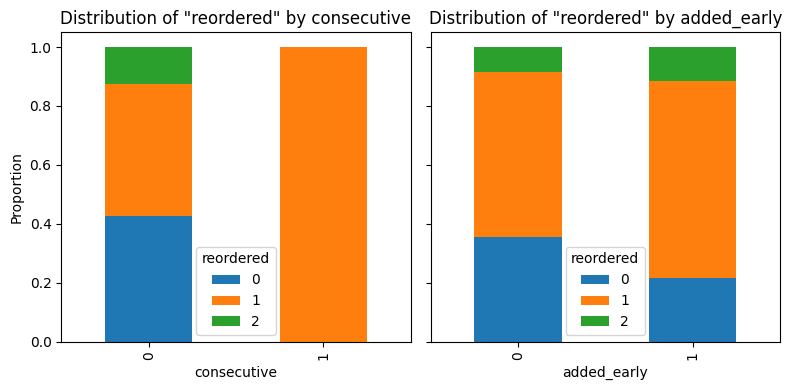

In [ ]:
# visualization of categorical features
categorical_columns = ['consecutive', 'added_early']

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

for i, column in enumerate(categorical_columns):
    # creating the table of frequency in each category
    grouped_data = train_set.groupby([column, 'reordered']).size().unstack(fill_value=0)

    # normalization in total
    normalized_data = grouped_data.div(grouped_data.sum(axis=1), axis=0)


    normalized_data.plot(kind='bar', stacked=True, ax=axes[i])  # Use `i` to index the axes
    axes[i].set_title(f'Distribution of "reordered" by {column}')
    axes[i].set_ylabel('Proportion')
    axes[i].set_xlabel(column)

plt.tight_layout()
plt.show()

1. Obviously consecutive appears only in  reorderd target. Will be considered with its value in analysis in further part.
2. Products added at the earlier stage of shopping are more often reordered.



### Outliers after feature engineering

In [ ]:
train_set.to_parquet('df_train_f.parquet', index = False)

In [ ]:
df_train = pd.read_parquet('./df_train_f.parquet')

In [ ]:
# checking again outliers based on data set with new features

stats_comparison = {}

numerical_features_outliers = ['num_orders', 'avg_num_products', 'avg_time_in_orders', 'days_last_prod_order', 'avg_days_between_prod_orders']

lower_bound = {}
upper_bound = {}
max_value = {}

for col in numerical_features_outliers:
    q1 = df_train[col].quantile(0.25)
    q3 = df_train[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound[col] = q1 - 1.5 * iqr
    upper_bound[col] = q3 + 1.5 * iqr
    max_value[col] = df_train[col].max()


    num_outliers_below = df_train[df_train[col] < lower_bound[col]].shape[0]
    num_outliers_above = df_train[df_train[col] > upper_bound[col]].shape[0]

    all_record = df_train.shape[0]

    print(f'Feature: {col}')
    print(f'Number of outliers below the lower bound: {num_outliers_below} and the lower bound is {round(lower_bound[col], 2)}')
    print(f'Number of outliers above the upper bound: {num_outliers_above} ({round(num_outliers_above/all_record*100, 2)}%) and the upper bound is {round(upper_bound[col], 2)}')
    print(f'Maximum value in this column is: {round(max_value[col], 2)}')

    print()

Feature: num_orders
Number of outliers below the lower bound: 0 and the lower bound is -38.0
Number of outliers above the upper bound: 0 (0.0%) and the upper bound is 98.0
Maximum value in this column is: 98

Feature: avg_num_products
Number of outliers below the lower bound: 0 and the lower bound is -3.5
Number of outliers above the upper bound: 525188 (2.72%) and the upper bound is 28.5
Maximum value in this column is: 82.33

Feature: avg_time_in_orders
Number of outliers below the lower bound: 0 and the lower bound is -4.59
Number of outliers above the upper bound: 565501 (2.93%) and the upper bound is 25.74
Maximum value in this column is: 30.0

Feature: days_last_prod_order
Number of outliers below the lower bound: 0 and the lower bound is -40.5
Number of outliers above the upper bound: 2315063 (12.01%) and the upper bound is 67.5
Maximum value in this column is: 365.0

Feature: avg_days_between_prod_orders
Number of outliers below the lower bound: 0 and the lower bound is -54.25


According to the IQR method, outliers are present in all selected columns except for the number of orders. In the average time between orders, the upper bound is close to the maximum, indicating a normal distribution within this variable. For further examination, the average number of products and days since the last product order will be considered together, as they share common characteristics with the average days between product orders.


In [ ]:
def show_outlier (df, column, col_list):

    '''
    This function shows boxplots for data with and without outliers for selected columns
    Args: column with outliers, list of columns - other variables which can show differences based on outliers in selected column
    Returns: boxplots for data with and without outliers and statistics for both outliers and not outliers
    '''
    stats = df[(df['feature'] == f'{column}_outliers') | (df['feature'] == f'{column}_no_outliers') ]

    display(stats)

    fig, axes = plt.subplots(len(col_list), 2, figsize=(2*len(col_list), 3*len(col_list)))

    # data set with outliers
    df_outliers = df_train[(df_train[column] < lower_bound[column]) | (df_train[column] > upper_bound[column])]
    # data set without outliers
    df_no_outliers = df_train[(df_train[column] >= lower_bound[column]) & (df_train[column] <= upper_bound[column])]

    for i, col in enumerate(col_list):

        # Boxplot for outliers data
        sns.boxplot(y=df_outliers[col], ax=axes[i, 0], color='red')
        axes[i, 0].set_title(f'{column} - with outliers', fontsize=8)

        # Boxplot for non-outliers data
        sns.boxplot(y=df_no_outliers[col], ax=axes[i, 1], color='green')
        axes[i, 1].set_title(f'{column} - without outliers', fontsize=8)

    plt.tight_layout()
    plt.show()

In [ ]:
# creating statistics for both data with outliers and without outliers for slected variables
df_stats = pd.DataFrame()

for col in numerical_features_outliers:
    df_outliers = df_train[(df_train[col] < lower_bound[col]) | (df_train[col] > upper_bound[col])]
    df_no_outliers = df_train[(df_train[col] >= lower_bound[col]) & (df_train[col] <= upper_bound[col])]

    df1 = df_outliers[['user_id', 'num_orders', 'avg_num_products', 'avg_time_in_orders', 'days_last_prod_order', 'ratio_product_reordered_times']].describe()
    df1['feature'] = f'{col}_outliers'
    df2 = df_no_outliers[['user_id', 'num_orders', 'avg_num_products', 'avg_time_in_orders', 'days_last_prod_order', 'ratio_product_reordered_times']].describe()
    df2['feature'] = f'{col}_no_outliers'

    new_df = pd.concat([df1, df2], axis = 0)

    df_stats = pd.concat([df_stats, new_df], axis=0)


### Outliers in average number of products

,user_id,num_orders,avg_num_products,avg_time_in_orders,days_last_prod_order,ratio_product_reordered_times,feature
count,5.251880e+05,5.251880e+05,5.251880e+05,5.247450e+05,5.251880e+05,5.251880e+05,avg_num_products_outliers
mean,1.049571e+05,2.683251e+01,3.367573e+01,1.277003e+01,2.566591e+01,2.885759e-01,avg_num_products_outliers
std,5.968898e+04,2.096834e+01,5.591667e+00,6.226249e+00,4.819702e+01,2.580606e-01,avg_num_products_outliers
min,2.380000e+02,2.000000e+00,2.852632e+01,2.000000e+00,0.000000e+00,0.000000e+00,avg_num_products_outliers
25%,5.451600e+04,1.000000e+01,2.966667e+01,7.741632e+00,0.000000e+00,6.000000e-02,avg_num_products_outliers
50%,1.070960e+05,2.100000e+01,3.188889e+01,1.115954e+01,8.000000e+00,2.300000e-01,avg_num_products_outliers
75%,1.578520e+05,3.900000e+01,3.566667e+01,1.623732e+01,2.800000e+01,4.800000e-01,avg_num_products_outliers
max,2.061080e+05,9.800000e+01,8.233333e+01,3.000000e+01,3.610000e+02,9.800000e-01,avg_num_products_outliers
count,1.875767e+07,1.875767e+07,1.875767e+07,1.875497e+07,1.875767e+07,1.875767e+07,avg_num_products_no_outliers
mean,1.027454e+05,3.340436e+01,1.256595e+01,1.110395e+01,2.738637e+01,2.009097e-01,avg_num_products_no_outliers


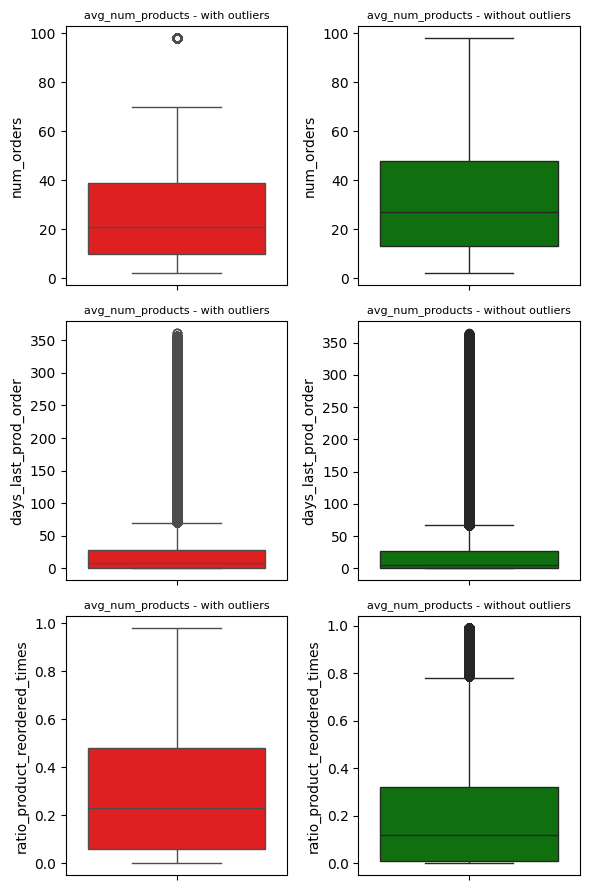

In [ ]:
show_outlier(df_stats, 'avg_num_products', ['num_orders','days_last_prod_order', 'ratio_product_reordered_times'])

* In the group of outliers there is quiet big range in number of average ordered products, because it is from 28.5 to 70
* At the beginning I've checked clients with the biggest number of products and these were clients who place more than few orders.
* It can be also observed that customers with higher average number of products per order buy less often and reorder more often same products. It looks like a pattern and important characteristics, so they buy more products, which they know, like or need for particular period. This is something that should stay in analysis as this can show particular group of clients.

### Outliers in number of days when product was last time ordered

,user_id,num_orders,avg_num_products,avg_time_in_orders,days_last_prod_order,ratio_product_reordered_times,feature
count,2.315063e+06,2.315063e+06,2.315063e+06,2.315063e+06,2.315063e+06,2.315063e+06,days_last_prod_order_outliers
mean,1.026226e+05,3.578730e+01,1.301328e+01,1.112310e+01,1.511208e+02,1.129456e-01,days_last_prod_order_outliers
std,5.948686e+04,2.326122e+01,6.242465e+00,5.389177e+00,7.151474e+01,1.019653e-01,days_last_prod_order_outliers
min,1.000000e+00,4.000000e+00,1.000000e+00,1.351052e+00,6.800000e+01,1.000000e-02,days_last_prod_order_outliers
25%,5.128000e+04,1.800000e+01,8.590909e+00,7.065359e+00,9.200000e+01,4.000000e-02,days_last_prod_order_outliers
50%,1.020890e+05,3.000000e+01,1.192308e+01,9.943804e+00,1.300000e+02,8.000000e-02,days_last_prod_order_outliers
75%,1.542860e+05,4.800000e+01,1.624138e+01,1.427692e+01,1.960000e+02,1.500000e-01,days_last_prod_order_outliers
max,2.062090e+05,9.800000e+01,5.766667e+01,3.000000e+01,3.650000e+02,9.400000e-01,days_last_prod_order_outliers
count,1.696780e+07,1.696780e+07,1.696780e+07,1.696465e+07,1.696780e+07,1.696780e+07,days_last_prod_order_no_outliers
mean,1.028306e+05,3.287582e+01,1.315831e+01,1.115287e+01,1.045096e+01,2.156249e-01,days_last_prod_order_no_outliers


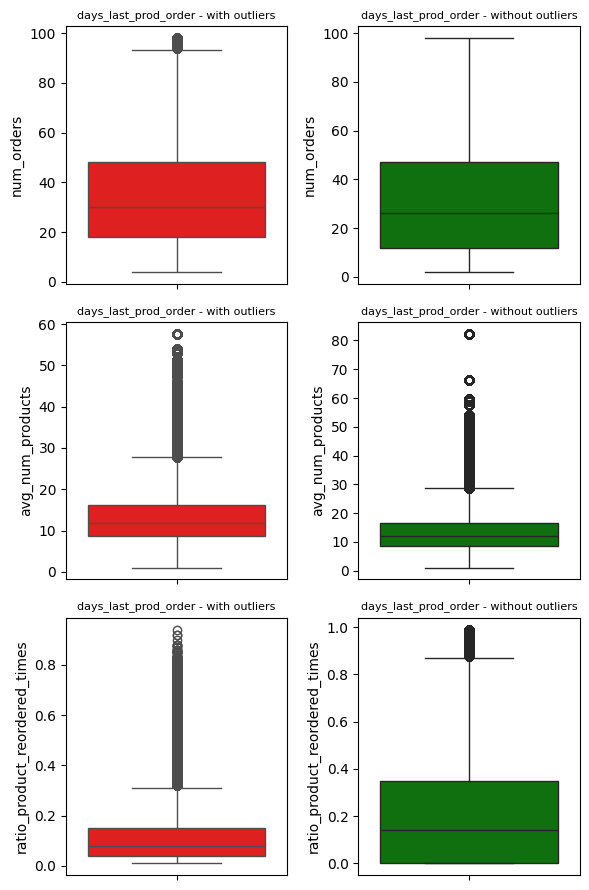

In [ ]:
show_outlier(df_stats, 'days_last_prod_order', ['num_orders', 'avg_num_products', 'ratio_product_reordered_times'])

In [ ]:
# creating data set with outliers in the number of days since last product purchase for further analysis
df_outliers_prod_last_ord = df_train[(df_train['days_last_prod_order'] < lower_bound['days_last_prod_order']) | (df_train['days_last_prod_order'] > upper_bound['days_last_prod_order'])].copy()
df_outliers_prod_last_ord['outliers_prod_last_order'] = 1

In [ ]:
# checking number of outliers per user and per product
df_outliers_prod_last_ord.groupby(['user_id', 'product_id']).size().reset_index(name='counts').sort_values(by = 'counts', ascending = False).head()

,user_id,product_id,counts
197121,19838,27695,4
1440662,144956,4487,4
27928,2967,581,4
115970,11755,10509,4
577227,58002,7751,4


In [ ]:
# adding flag for outliers in the number of days since last product purchase to the main data set to check how many purchases of these products appeared per client
outlier_map = df_outliers_prod_last_ord.set_index(['user_id', 'product_id'])['outliers_prod_last_order'].to_dict()
df_train['outliers_prod_last_order'] = df_train.set_index(['user_id', 'product_id']).index.map(outlier_map)

In [ ]:
# checking the number of total orders for products with outliers
df_train[df_train['outliers_prod_last_order'] == 1].groupby(['user_id', 'product_id'])['order_number'].count().sort_values(ascending = False)

user_id  product_id
205147   30718         73
111799   25199         73
149859   9839          73
111799   26047         72
103593   47209         70
                       ..
95192    48093          2
         22890          2
         2073           2
95191    42633          2
206209   48742          2
Name: order_number, Length: 2043176, dtype: int64

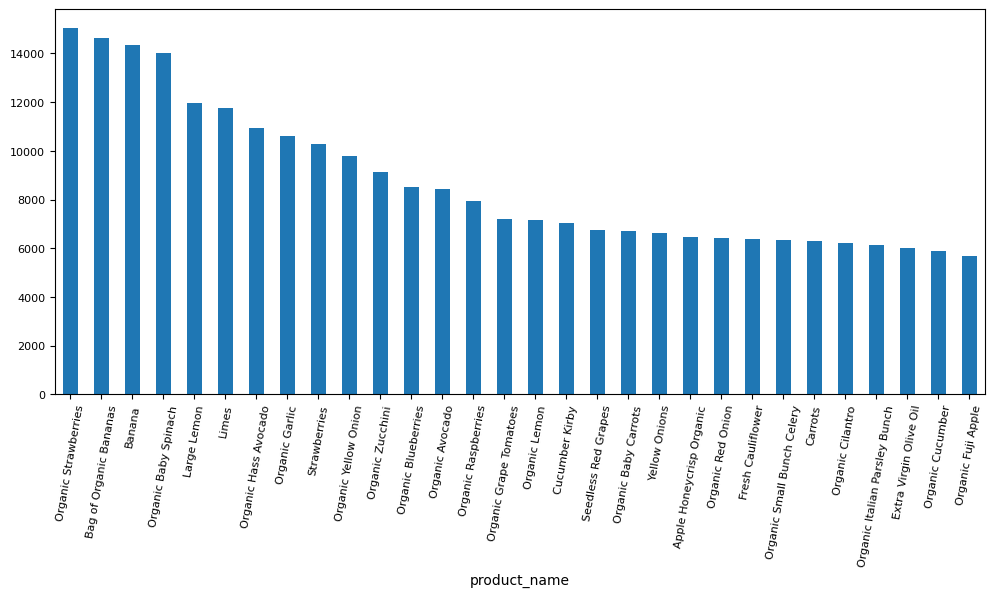

In [ ]:
df_outliers_prod_last_ord['product_name'].value_counts().head(30).plot(kind = 'bar', figsize = (12, 5), fontsize = 8)
plt.xticks(rotation=80)
plt.show()

In [ ]:
# this column is not needed for further analysis, so I drop it
df_train.drop('outliers_prod_last_order', axis = 1, inplace = True)

* There are really long breaks in group of outliers up to 1 year; comparing to maximum 71 days for non-outliers.
* It is visible that products with longer breaks in purchase have got lower ratio for reordering
* After checking data frame based on outliers we can observe that it is connected mostly with generic products vegetables, so there is no visible pattern it is about just specific products.
* Another thing is that sometimes extreme breaks appear few times in same product for same client - so this is the part of some pattern.
* The last thing after joining outlier flag to the main set is that these extreme values appear in products which were bought by the same client even more than 70 times and deleting them would harm the history of its ordering.
* I am going to leave these records and the same I decide about next variable which should be average number of days when product was last time ordered, which is totally dependant on actual variables.

### Creating additional features for training (phase 2, post - initial deployment)

Need to create more generalized variables that can avoid data leakage connected with the time sequence as some preliminary variables can't be used.

In [ ]:
def reset_df():
    return df_train.copy()

In [ ]:
df = reset_df()

Features connected with consecutive reorder

In [ ]:
# counting sum of consecutive orders for each product
consecutive_sum = df.groupby(['user_id', 'product_id'])['consecutive'].sum()

# sum of all orders for each user and product
total_orders_prod = df.groupby(['user_id', 'product_id'])['order_id'].count()

consecutive_ratio = consecutive_sum / total_orders_prod

# mappint the result to the original data frame and creating variable
df['ratio_consecutive_reorders'] = df.set_index(['user_id', 'product_id']).index.map(consecutive_ratio)

# max number of consecutive reorders of product for each user
df['max_consecutive_reorders'] = df.groupby(['user_id', 'product_id'])['consecutive_reorder'].transform('max')

Using mode in days between client's orders to create additional variables

In [ ]:
# deleting duplicates for orders (user_id, order_id)
unique_orders = df[df['order_number'] > 1][['user_id', 'order_id', 'days_since_prior_order']].drop_duplicates()

# counting mode for days between orders for each user
user_mode_days = unique_orders.groupby('user_id')['days_since_prior_order'].agg(lambda x: x.mode().mean() if not x.mode().empty else np.nan)

# mapping the mode days to the data frame
df['days_order_mode'] = df['user_id'].map(user_mode_days)

# two new variables reflecting mode correlation with time in products orders and time in client's orders
df['ratio_avg_time_prod_order_to_mode'] = np.where(df['days_order_mode'] == 0, 0, df['avg_days_between_prod_orders'] / df['days_order_mode'])

df['ratio_mode_to_avg_time_order'] = np.where(df['avg_time_in_orders'] == 0, 0, df['days_order_mode']/df['avg_time_in_orders'])

Features connected with product position in the basket

In [ ]:
# Total number of products in the order
df['total_products_in_order'] = df.groupby('order_id')['add_to_cart_order'].transform('max')

# Ratio of the position to all products in the order
df['position_ratio'] = df['add_to_cart_order'] / df['total_products_in_order']

# Average position ratio for each user and product
df['user_product_avg_position_ratio'] = df.groupby(['user_id', 'product_id'])['position_ratio'].transform('mean')

# creating mean from variable added early as this categorical variable wasn't so informative
df['added_early_prod_mean'] = df.groupby(['user_id', 'product_id'])['added_early'].transform('mean')

In [ ]:
# there is 6977 cases where product was bought just once and this is the reason why it has got 100% ratio of early added products, to consider if it is for change
df[df['added_early_prod_mean'] == 1].groupby('product_id')['order_number'].nunique().value_counts()[:1]

,count
order_number,
1,6977


Variables connected with orders

In [ ]:
# decided to change order number into order position to assign all orders in test set to 0
df['order_position'] = df['order_number'] / df['num_orders']

In [ ]:
# variable reflecting ratio between time in product orders to time in orders in general
df['ratio_avg_time_prod_order_to_average_order_time'] =np.where(df['avg_time_in_orders'] == 0, 0, df['avg_days_between_prod_orders'] / df['avg_time_in_orders'])


In [ ]:
# counting the standard deviation for days since prior order for each user
df['std_time_between_orders'] = df.groupby('user_id')['days_since_prior_order'].transform('std')

Counting variables connected with day and hour

In [ ]:
# changing hours into categories
def categorize_hour(hour):
    if 0 <= hour <= 6:
        return 'night'
    elif 7 <= hour <= 11:
        return 'morning'
    elif 12 <= hour <= 17:
        return 'day'
    else:
        return 'evening'

df['hour_category'] = df['order_hour_of_day'].apply(categorize_hour)

In [ ]:
# changing days into categories
def categorize_day(day):
    if day in [0, 6]:
        return 'weekend'
    elif day in [1,2,3]:
        return 'first_part_week'
    else:
        return 'second_part_week'

df['day_category'] = df['order_dow'].apply(categorize_day)

In [ ]:
# counting the percentage of orders made in part of a week and day for each user
hour_percent_user = (
    df.groupby(['user_id', 'hour_category'])['order_id'].nunique()
    .div(df.groupby('user_id')['order_id'].nunique(), level=0)
    .unstack(fill_value=0).round(2))

day_percent_user = (
    df.groupby(['user_id', 'day_category'])['order_id'].nunique()
    .div(df.groupby('user_id')['order_id'].nunique(), level=0)
    .unstack(fill_value=0).round(2))

In [ ]:
# reset index to have user_id as a column
hour_percent_user.reset_index(inplace = True)
day_percent_user.reset_index(inplace = True)

In [ ]:
# merging new columns to the main df
df = df.merge(hour_percent_user, on = 'user_id', how = 'left')
df = df.merge(day_percent_user, on = 'user_id', how = 'left')

Features connected with class 2 - usefull to differentiate it from 0 and 1 classes

In [ ]:
# variable to identify what is the percent of reordered products in order in average per client
df['sum_prod_order'] = df.groupby('order_id')['reordered'].transform(lambda x: (x == 1).sum())
df['ratio_reordered_products_in_order'] = df['sum_prod_order'] / df['total_products_in_order']
df['avg_ratio_reordered_products_user'] = df.groupby('user_id')['ratio_reordered_products_in_order'].transform('mean')

# ratio of orders consisting only of not reordered products to all user's orders
new_product_orders = df[df['reordered'] == 2].groupby('user_id')['order_number'].nunique()
total_orders = df.groupby('user_id')['order_id'].nunique()
percent_new_product_orders = (new_product_orders / total_orders)
df['percent_new_product_orders'] = df['user_id'].map(percent_new_product_orders)


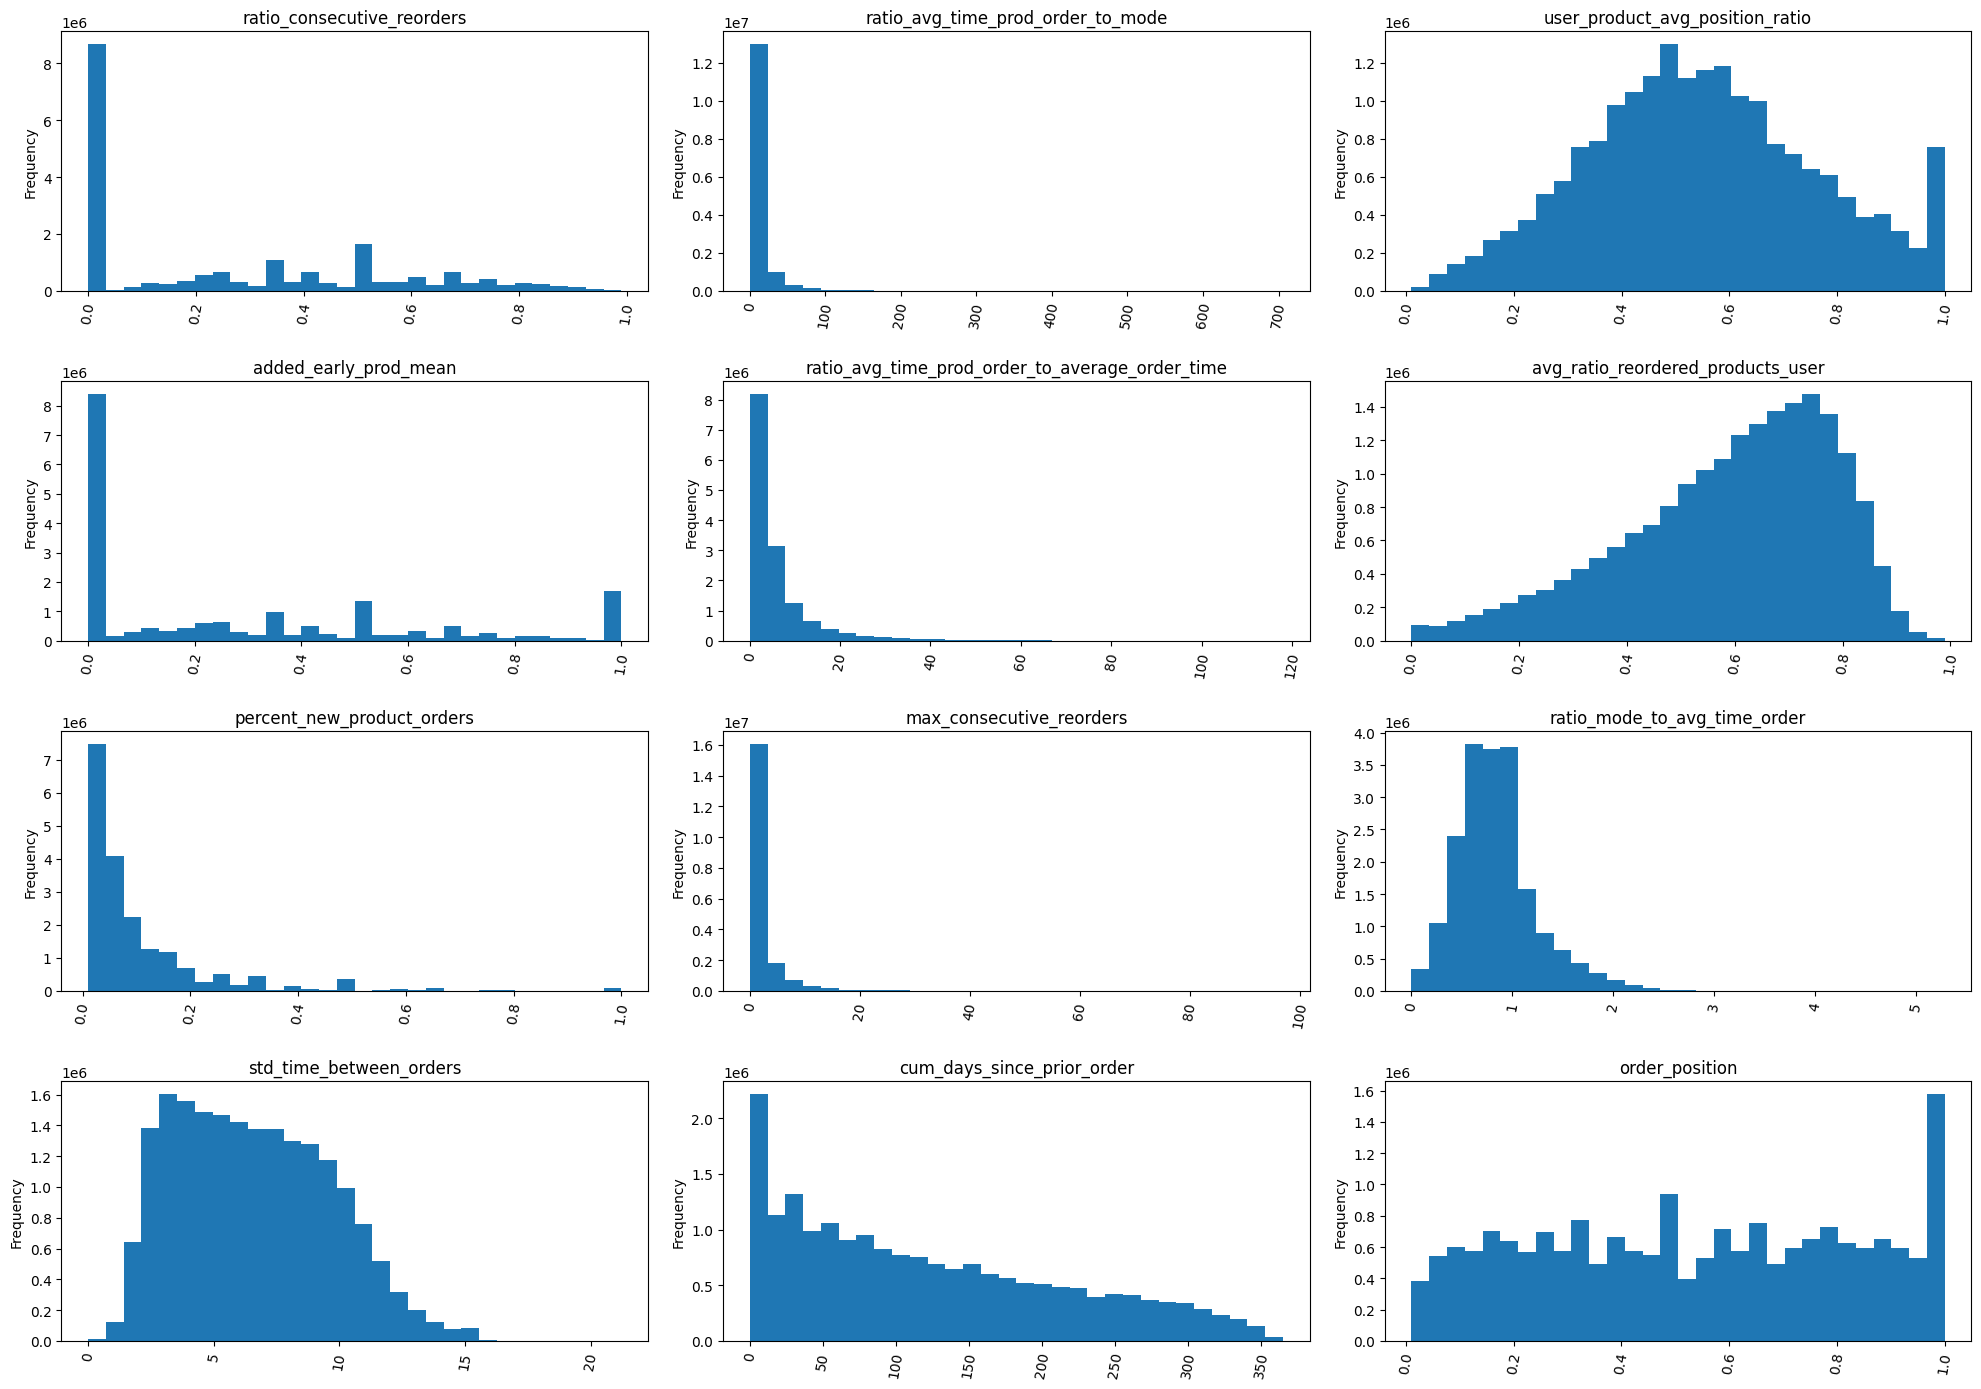

In [ ]:
# visualization of added features distribution
col_num = ['ratio_consecutive_reorders', 'ratio_avg_time_prod_order_to_mode', 'user_product_avg_position_ratio', 'added_early_prod_mean', 'ratio_avg_time_prod_order_to_average_order_time', 'avg_ratio_reordered_products_user', 'percent_new_product_orders', 'max_consecutive_reorders', 'ratio_mode_to_avg_time_order', 'std_time_between_orders', 'cum_days_since_prior_order', 'order_position']

fig, axes = plt.subplots(4, 3, figsize = (20, 14))

for i, column in enumerate(col_num):
    row = i // 3
    col = i % 3

    df[column].plot(kind='hist', ax=axes[row, col], bins=30)

    axes[row, col].set_title(column)
    axes[row, col].tick_params(axis = 'x', rotation = 80, labelsize = 10)
    axes[row, col].set_xlabel('')

plt.tight_layout()
plt.show()

1. The histograms show that most customers tend to reorder consecutively or add products early in their shopping sessions, highlighting common behaviors in repeat purchasing.
2. Features like the average time between orders and standard deviation of order times reveal that while some shopping patterns are consistent, others vary, suggesting different shopping frequencies and habits among users.
3. High peaks in the distribution of ratios and the position of reordered items indicate that certain products are either consistently favored or occasionally purchased.

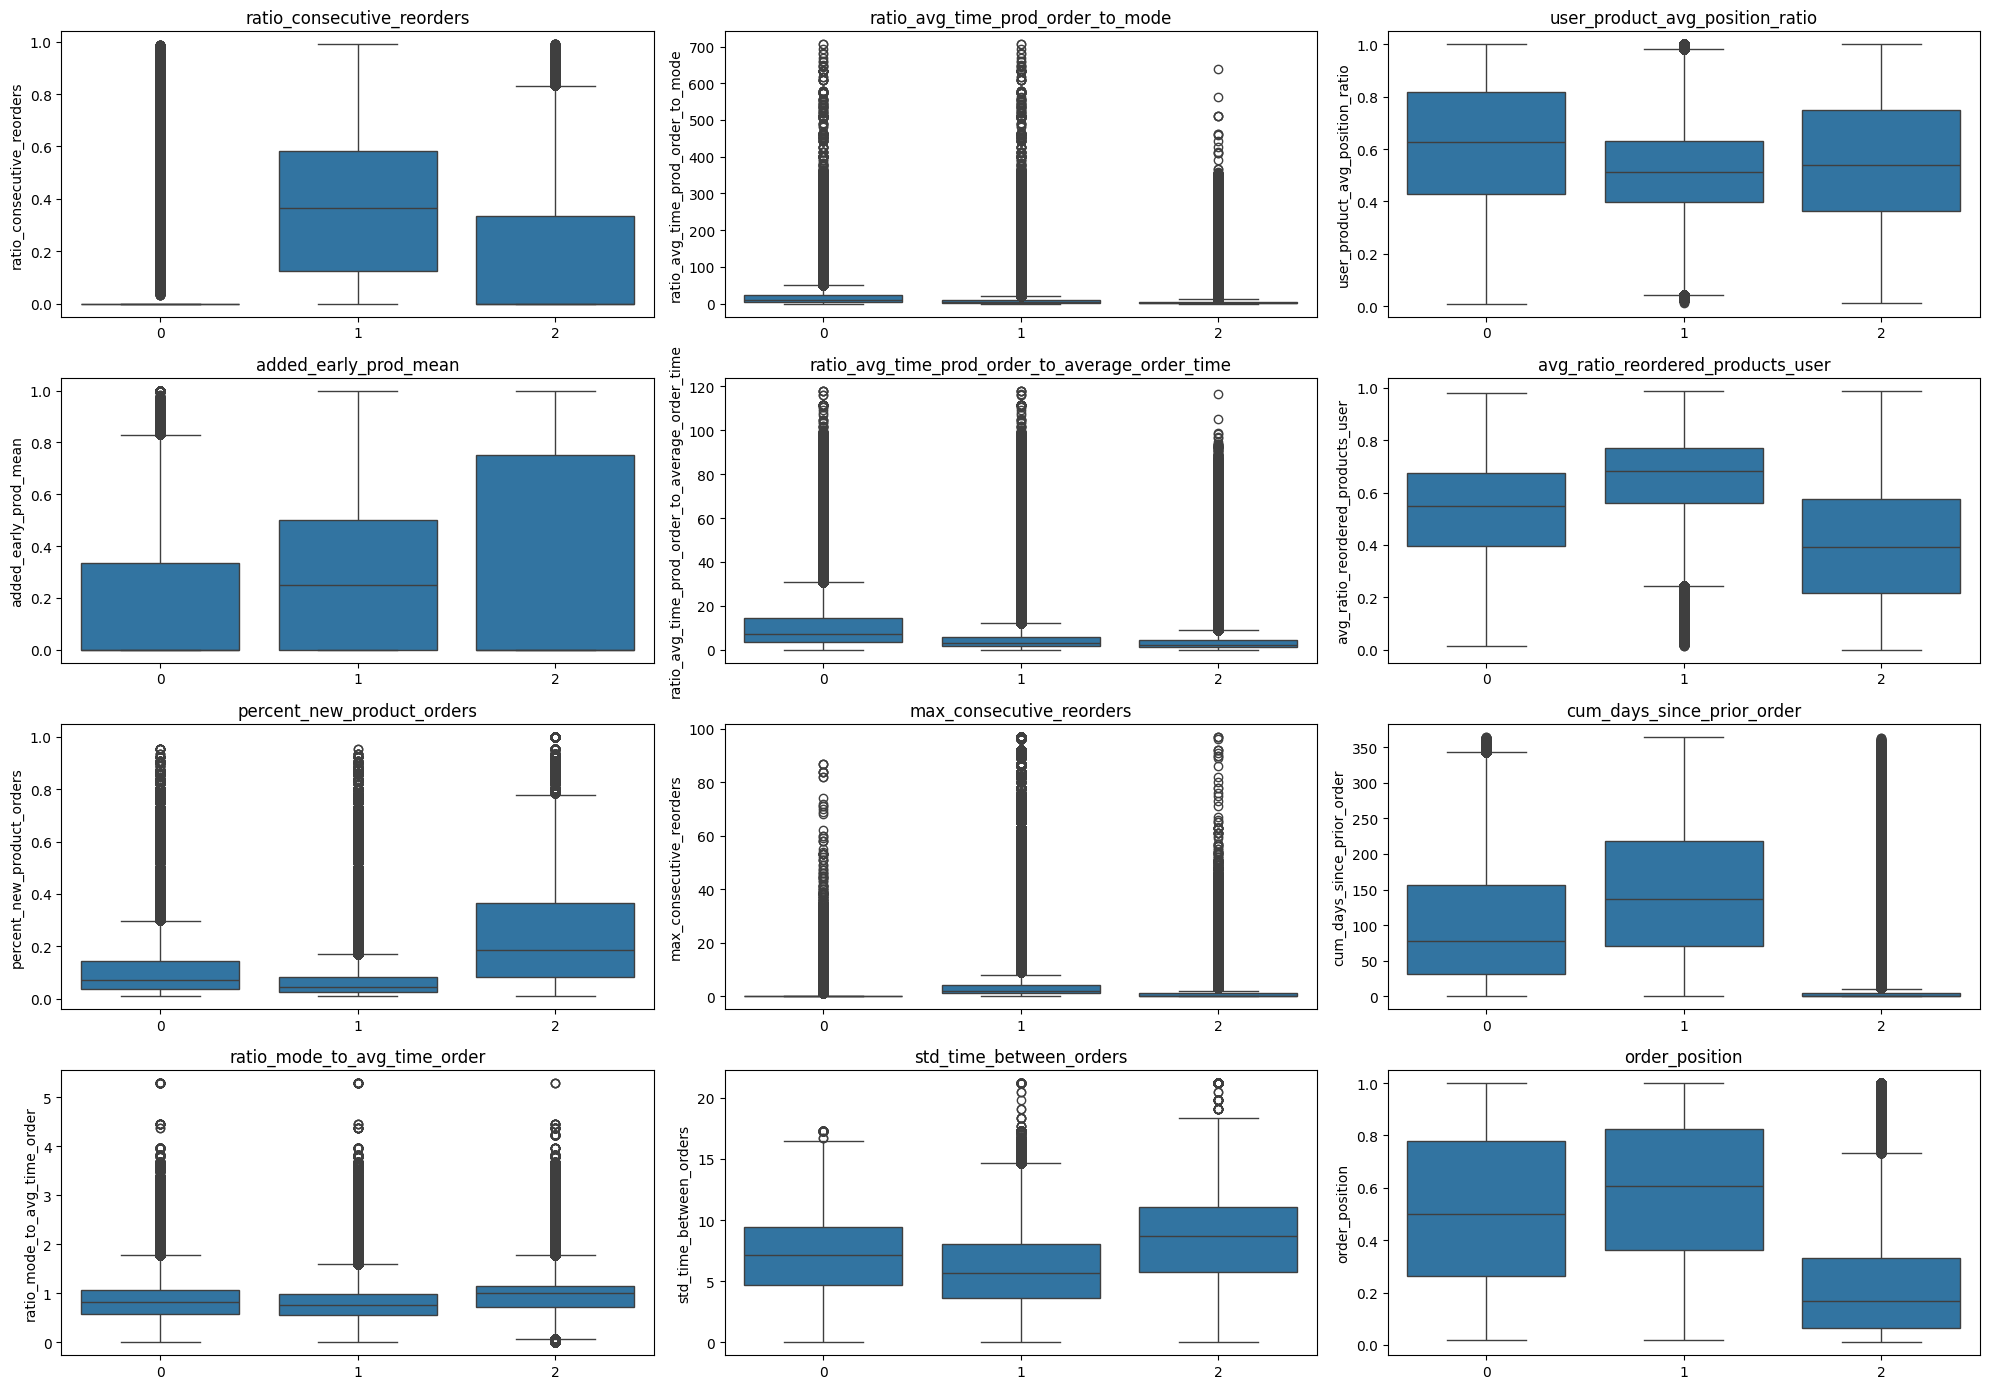

In [ ]:
# visualization of added features distribution takin into consideration target
col_num = ['ratio_consecutive_reorders', 'ratio_avg_time_prod_order_to_mode', 'user_product_avg_position_ratio', 'added_early_prod_mean', 'ratio_avg_time_prod_order_to_average_order_time', 'avg_ratio_reordered_products_user', 'percent_new_product_orders', 'max_consecutive_reorders', 'cum_days_since_prior_order', 'ratio_mode_to_avg_time_order', 'std_time_between_orders', 'order_position']

fig, axes = plt.subplots(4, 3, figsize = (20, 14))

for i, column in enumerate(col_num):
    row = i // 3
    col = i % 3

    sns.boxplot(x = df['reordered'], y = df[column],  ax = axes[row, col])

    axes[row, col].set_title(column)
    axes[row, col].tick_params(axis = 'x', labelsize = 10)
    axes[row, col].set_xlabel('')


plt.tight_layout()
plt.show()

* It’s clear that products that are reordered feature a higher ratio of consecutive orders compared to all orders.
* Reordered products are generally added to the cart earlier than products that are not reordered or are ordered for the first time.
* Orders consisting only of new products have the highest average of being added early to the cart, which may be related to these products being purchased only once. Nonetheless, they are typically placed at the beginning of the basket.
* Products that are not reordered tend to have longer intervals between orders compared to the average interval between all orders for clients.
* Clients who buy products for the first time and do not reorder them exhibit a lower ratio of reordered products compared to all products they order. Additionally, these clients show a higher percentage of orders consisting solely of new products.
* The cumulative days since the prior order indicate that reordered products accumulate a higher range of days, suggesting that these products are consistently repurchased over longer cycles.
* Orders consisting solely of new products display the highest standard deviation in the time between orders, which can confirm that these orders are rather spontaneous. Additionally, the order position indicates that these were not the client’s initial orders but were placed towards the end of the customer’s purchasing history.

In [ ]:
df.to_parquet('df_features_train.parquet', index=False)

In [ ]:
df = pd.read_parquet('df_features_train.parquet')

In [ ]:
# deleting variables which were used to count new features and those that can provide leakage

df_train_nf = df.drop(['added_early', 'cum_days_since_prior_order_prod', 'days_last_prod_order', 'consecutive', 'groupId', 'consecutive_reorder', 'days_order_mode', 'product_reordered_times', 'total_products_in_order', 'position_ratio', 'sum_prod_order',
       'ratio_reordered_products_in_order', 'hour_category', 'day_category',], axis = 1)

In [ ]:
# checking NaN values
df_train_nf.isna().sum()

,0
order_id,0
product_id,0
add_to_cart_order,0
reordered,0
product_name,0
aisle_id,0
department_id,0
aisle,0
department,0
user_id,0


In [ ]:
df_train_nf[df_train_nf['ratio_avg_time_prod_order_to_mode'].isna()]['reordered'].value_counts()

,count
reordered,
0,3814489
2,930174
1,2602


In [ ]:
df_train_nf[(df_train_nf['ratio_avg_time_prod_order_to_mode'].isna()) & (df_train_nf['reordered'] == 1)].head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,num_orders,avg_num_products,avg_time_in_orders,product_rank,aisle_rank,department_rank,cum_days_since_prior_order,avg_days_between_prod_orders,ratio_product_reordered_times,user_prod_avg_pos_cart,user_prod_max_pos,ratio_consecutive_reorders,max_consecutive_reorders,ratio_avg_time_prod_order_to_mode,ratio_mode_to_avg_time_order,user_product_avg_position_ratio,added_early_prod_mean,order_position,ratio_avg_time_prod_order_to_average_order_time,day,evening,morning,night,first_part_week,second_part_week,weekend,std_time_between_orders,avg_ratio_reordered_products_user,percent_new_product_orders
8597,2393725,21137,5,1,Organic Strawberries,24,4,fresh fruits,produce,108,prior,2,0,13,0.0,6,9.833333,26.780488,2.0,4.0,7.0,0.0,NaN,0.17,3.5,5,0.5,1,NaN,1.120219,0.388889,0.5,0.333333,NaN,0.67,0.17,0.17,0.0,0.33,0.00,0.67,13.371376,0.457627,0.166667
8599,2393725,21249,7,1,Organic Ramen Noodles,66,6,asian foods,international,108,prior,2,0,13,0.0,6,9.833333,26.780488,2.0,2.0,2.0,0.0,NaN,0.17,7.0,7,0.5,1,NaN,1.120219,0.777778,0.0,0.333333,NaN,0.67,0.17,0.17,0.0,0.33,0.00,0.67,13.371376,0.457627,0.166667
8608,2393725,30489,8,1,Original Hummus,67,20,fresh dips tapenades,deli,108,prior,2,0,13,0.0,6,9.833333,26.780488,2.0,6.0,4.0,0.0,NaN,0.17,6.0,8,0.5,1,NaN,1.120219,0.666667,0.0,0.333333,NaN,0.67,0.17,0.17,0.0,0.33,0.00,0.67,13.371376,0.457627,0.166667
8613,2393725,38289,6,1,Pomegranate Italian Soda,98,7,juice nectars,beverages,108,prior,2,0,13,0.0,6,9.833333,26.780488,2.0,2.0,4.0,0.0,NaN,0.17,5.5,6,0.5,1,NaN,1.120219,0.611111,0.0,0.333333,NaN,0.67,0.17,0.17,0.0,0.33,0.00,0.67,13.371376,0.457627,0.166667
83409,3095232,812,1,1,Healthy Grains Oats & Honey Clusters with Toas...,57,14,granola,breakfast,923,prior,2,5,11,0.0,11,6.636364,15.278689,2.0,2.0,6.0,0.0,NaN,0.09,2.5,4,0.5,1,NaN,0.327253,0.416667,0.5,0.181818,NaN,0.36,0.27,0.36,0.0,0.18,0.55,0.27,11.575262,0.191781,0.454545


In [ ]:
# checking if this is only about 0 and 2 classes
df_train_nf[df_train_nf['avg_days_between_prod_orders'].isna()]['reordered'].value_counts()

,count
reordered,
0,3831988
2,937077
1,3883


In [ ]:
# class 1 have to be checked if there is lack of information about days since prior order, because these orders were made same day
def check_orders_dame_day (df, column):
  print(df[(df[column].isna()) & (df['reordered'] == 1) & (df_train_nf['days_since_prior_order'] > 0)].head().shape[0])

columns_to_check = ['avg_time_in_orders', 'avg_days_between_prod_orders', 'ratio_avg_time_prod_order_to_mode', 'ratio_mode_to_avg_time_order', 'ratio_avg_time_prod_order_to_average_order_time']

for column in columns_to_check:
    check_orders_dame_day(df_train_nf, column)

0
0
0
0
0


In [ ]:
# after research filling all missing values with 0 what is consistent with that it is about not reordered product or products reordered in same day when the time between orders is 0
df_train_nf.fillna({'avg_time_in_orders' : 0, 'avg_days_between_prod_orders' : 0, 'ratio_avg_time_prod_order_to_mode' : 0, 'ratio_mode_to_avg_time_order' : 0, 'ratio_avg_time_prod_order_to_average_order_time' : 0}, inplace = True)

### Adding new features created based on training set to the test set

In [ ]:
df_test_nf = pd.read_parquet('data_test.parquet')

There can be added only variables that were prepared based on traing test to avoid data leakage

In [ ]:
# mapping the variables on the user level
user_features = df_train_nf[['user_id', 'num_orders', 'avg_time_in_orders', 'percent_new_product_orders', 'avg_ratio_reordered_products_user', 'avg_num_products', 'ratio_mode_to_avg_time_order', 'std_time_between_orders',
                             'day', 'evening', 'morning', 'night', 'first_part_week', 'second_part_week', 'weekend']].drop_duplicates('user_id')
df_test_nf = df_test_nf.merge(user_features, on='user_id', how='left')

# mapping the variables on the product level
product_features = df_train_nf[['user_id', 'product_id', 'ratio_product_reordered_times', 'avg_days_between_prod_orders', 'product_rank', 'user_prod_avg_pos_cart', 'user_prod_max_pos', 'ratio_consecutive_reorders',
                                'user_product_avg_position_ratio', 'added_early_prod_mean', 'max_consecutive_reorders', 'ratio_avg_time_prod_order_to_mode', 'ratio_avg_time_prod_order_to_average_order_time']].drop_duplicates(['user_id', 'product_id'])
df_test_nf = df_test_nf.merge(product_features, on=['user_id', 'product_id'], how='left')

# mapping the variables on the aisle level
aisle_features = df_train_nf[['user_id', 'aisle_id', 'aisle_rank']].drop_duplicates(['user_id', 'aisle_id'])
df_test_nf = df_test_nf.merge(aisle_features, on=['user_id', 'aisle_id'], how='left')

# mapping the variables on the department level
department_features = df_train_nf[['user_id', 'department_id', 'department_rank']].drop_duplicates(['user_id', 'department_id'])
df_test_nf = df_test_nf.merge(department_features, on=['user_id', 'department_id'], how='left')

# set up the variables for the test set, number 1 means that order is the newest one
df_test_nf['order_position'] = 1.0

# mapping the last value for the variable cum_days_since_prior_order for each user to the test set
last_cum_days = df_train_nf.groupby('user_id')['cum_days_since_prior_order'].last()
df_test_nf['cum_days_since_prior_order'] = df_test_nf['user_id'].map(last_cum_days)

In [ ]:
# checking NaN values after merging
df_test_nf.isna().sum()

,0
order_id,0
product_id,0
add_to_cart_order,0
reordered,0
product_name,0
aisle_id,0
department_id,0
aisle,0
department,0
user_id,0


In [ ]:
# checking how many pairs user-product from test set lack in train set
train_pairs = set(zip(df_train_nf['user_id'], df_train_nf['product_id']))

test_pairs = set(zip(df_test_nf['user_id'], df_test_nf['product_id']))
missing_pairs = test_pairs - train_pairs

print(f"The number of lacking pairs in test set: {len(missing_pairs)}")

len(test_pairs)

Liczba brakujących par w test: 561851


1358931

In [ ]:
def check_merge(df1, df2, col_to_check, connector):
    '''

    Function to check if the merge was successful and if all missing values are not available in the train set.
    Args: two data frames that we compare, column to check, connector for particular column
    Returns: number of missing values in the test set that are available in the train set

    '''

    # Extracting user id and connector id for column that is checked for missing values
    missing_data = df1[df1[col_to_check].isna()][['user_id', connector]]

    # Creating pairs (user_id, connector) for fast check
    missing_keys = set(zip(missing_data['user_id'], missing_data[connector]))
    df2_keys = set(zip(df2['user_id'], df2[connector]))

    # Comparing missing values in test set with train set
    found_records = missing_keys & df2_keys
    counter = len(found_records)

    return counter

In [ ]:
missing_values = ['ratio_product_reordered_times',
       'avg_days_between_prod_orders', 'product_rank',
       'user_prod_avg_pos_cart', 'user_prod_max_pos',
       'ratio_consecutive_reorders', 'user_product_avg_position_ratio',
       'added_early_prod_mean', 'max_consecutive_reorders',
       'ratio_avg_time_prod_order_to_mode',
       'ratio_avg_time_prod_order_to_average_order_time']

In [ ]:
# confirming if missing values for new features are not available in the train set
for column in missing_values:
    in_train_set = check_merge(df_test_nf, df_train_nf, column, 'product_id')
    print(in_train_set)

0
0
0
0
0
0
0
0
0
0
0


In [ ]:
# confirming if missing values for new features are not available in the train set
aisle_missing = check_merge(df_test_nf, df_train_nf, 'aisle_rank', 'aisle_id')
print(aisle_missing)
department_missing = check_merge(df_test_nf, df_train_nf, 'department_rank', 'department_id')
print(department_missing)

0
0


In [ ]:
# filling missing values with 0 as the missing values are for products, aisles, departments that don't have history in the train set
df_test_nf.fillna({'ratio_product_reordered_times' : 0,
       'avg_days_between_prod_orders' : 0, 'product_rank' : 0,
       'user_prod_avg_pos_cart' : 0, 'user_prod_max_pos' : 0,
       'ratio_consecutive_reorders' : 0, 'user_product_avg_position_ratio' : 0,
       'added_early_prod_mean' : 0, 'max_consecutive_reorders' : 0,
       'ratio_avg_time_prod_order_to_mode' : 0,
       'ratio_avg_time_prod_order_to_average_order_time' : 0, 'aisle_rank' : 0, 'department_rank' : 0}, inplace = True)

In [ ]:
# setting same direction of columns in both datasets
df_test_nf = df_test_nf[df_train_nf.columns]

In [ ]:
numerical_binary_col = ['add_to_cart_order', 'order_number','days_since_prior_order',
                        'num_orders', 'avg_num_products','avg_time_in_orders',
                        'product_rank','aisle_rank',
                        'department_rank', 'cum_days_since_prior_order', 'avg_days_between_prod_orders',
                        'ratio_product_reordered_times', 'user_prod_avg_pos_cart',
                        'user_prod_max_pos', 'ratio_consecutive_reorders', 'max_consecutive_reorders',
                        'ratio_avg_time_prod_order_to_mode', 'ratio_mode_to_avg_time_order',
                        'order_position', 'user_product_avg_position_ratio',
                        'ratio_avg_time_prod_order_to_average_order_time',
                        'added_early_prod_mean', 'percent_new_product_orders',
                        'avg_ratio_reordered_products_user', 'std_time_between_orders',
                        'day', 'evening', 'morning', 'night', 'first_part_week', 'second_part_week',
                        'weekend', 'reordered']

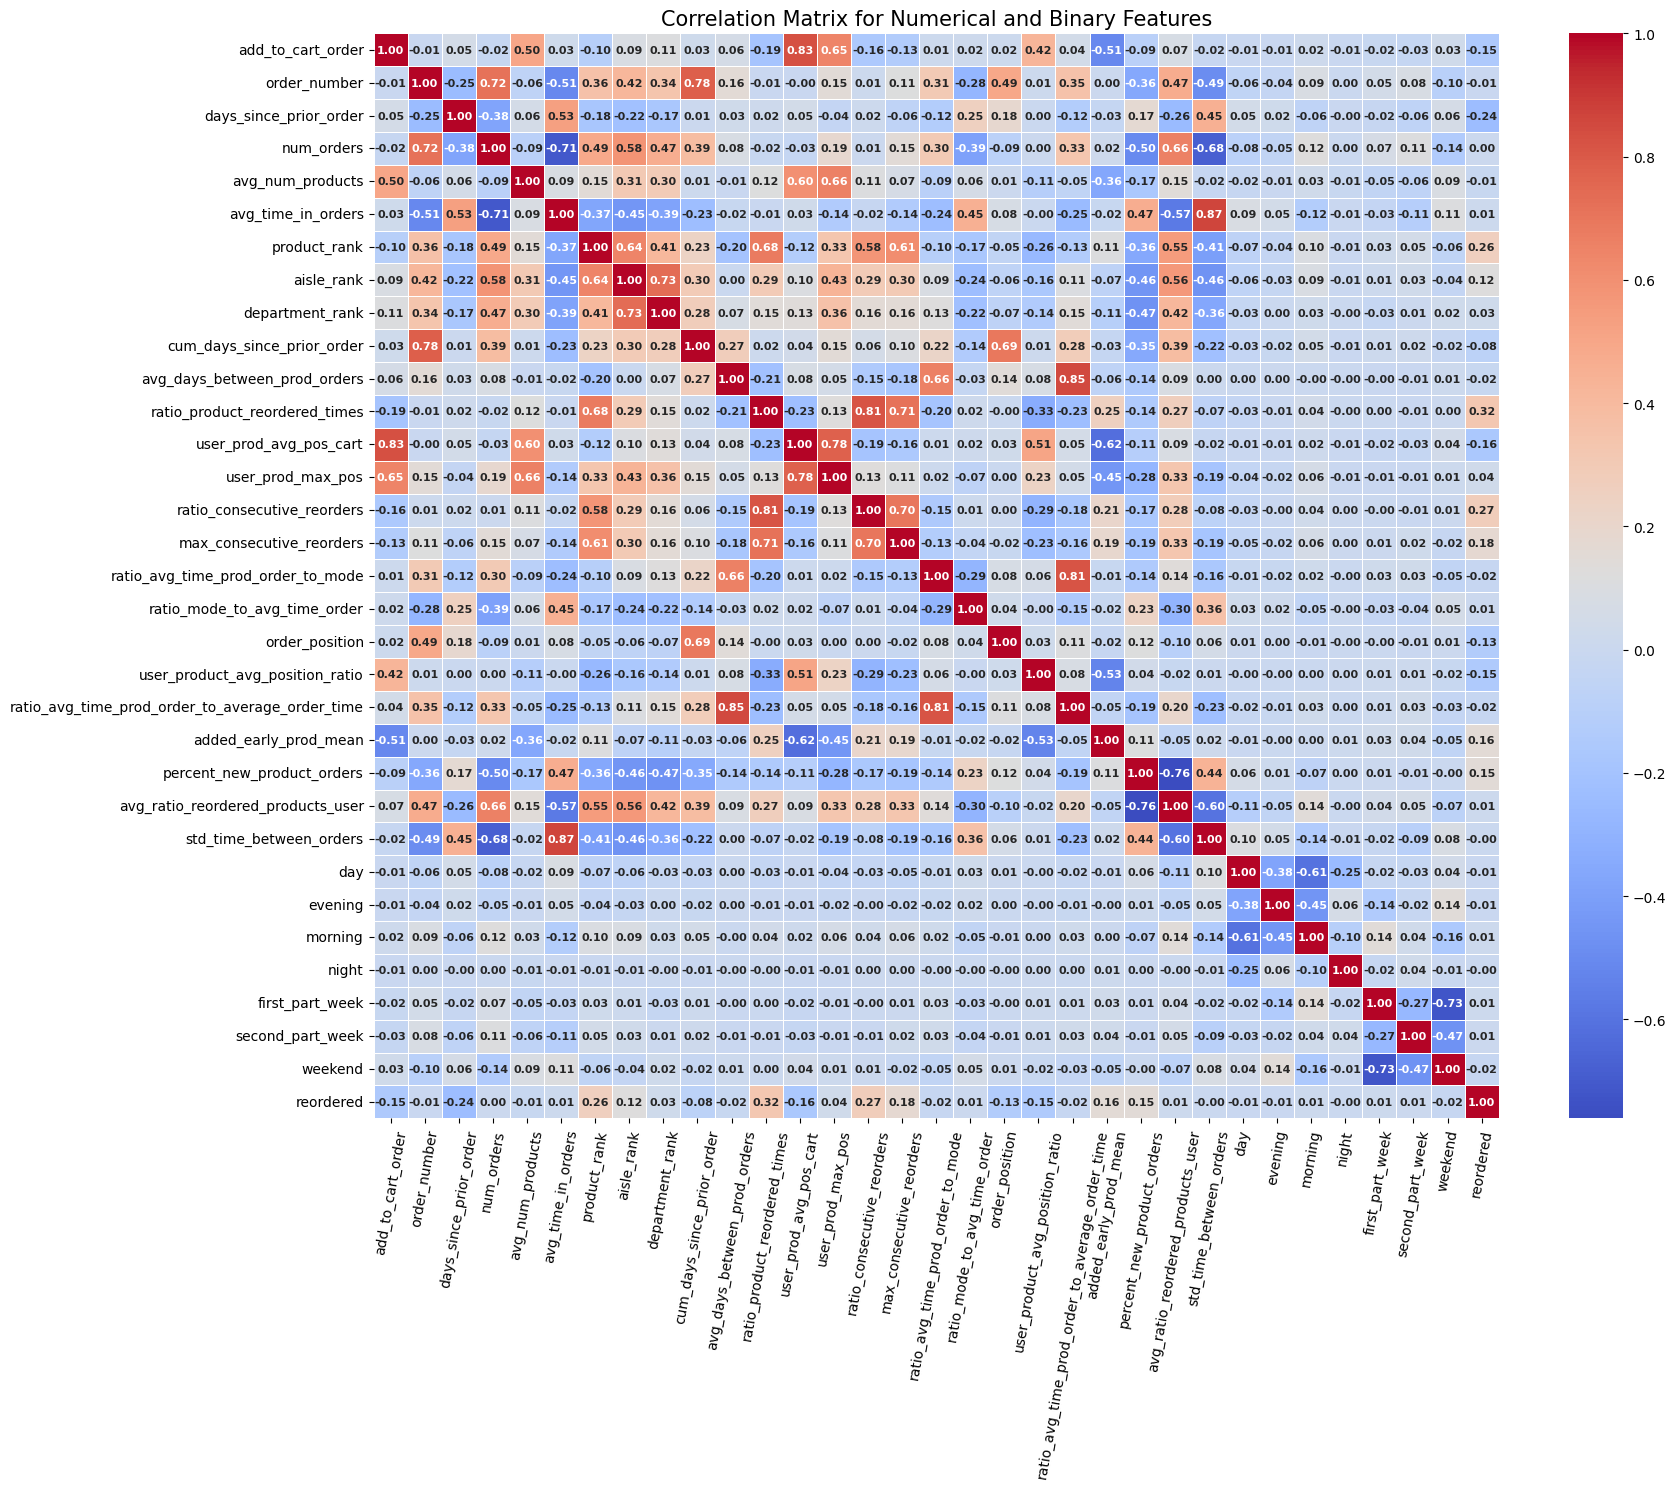

In [ ]:
correlation_matrix = df_train_nf[numerical_binary_col].corr()

plt.figure(figsize=(18, 15))

sns.heatmap(
    correlation_matrix,
    annot=True,
    annot_kws={'size': 8, 'weight': 'bold'},
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5,
    cbar=True
)

plt.xticks(rotation=80, fontsize=10)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix for Numerical and Binary Features', fontsize=15)
plt.tight_layout()
plt.show()

The correlation matrix provides a broad overview of the relationships between variables, which is crucial, especially when the target variable is multiclass and categorical. This makes it challenging to directly observe correlations with the target, but the matrix is still valuable for identifying highly correlated variables.

We observe strong correlations between several pairs of features, such as:
*	add_to_cart_order and user_prod_avg_pos_cart, suggesting redundancy. To prevent data leakage, add_to_cart_order will be removed.
*	order_number shows a strong correlation with both cum_days_since_prior_order and num_orders, indicating it may carry redundant information and will also be removed to reduce complexity.

For now, the focus is on removing variables that pose a risk of data leakage. Remaining variables will be retained for further evaluation of their utility after initial model deployment.

In [ ]:
df_train_nf.to_parquet('train_set.parquet', index = False)
df_test_nf.to_parquet('test_set.parquet', index = False)

In [5]:
train_set = pd.read_parquet('./train_set.parquet')
test_set = pd.read_parquet('./test_set.parquet')

In [6]:
# OTHER - deleting columns which will not be useful in building model, these which were used for counting new features and those that have high correlation
col_to_delete = ['add_to_cart_order', 'product_id', 'aisle_id', 'department_id', 'order_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']

In [7]:
train_set.drop(col_to_delete, axis = 1, inplace = True)
test_set.drop(col_to_delete, axis = 1, inplace = True)

In [9]:
# GRU - deleting columns which will not be useful in building model, these which were used for counting new features and those that have high correlation
col_to_delete = ['add_to_cart_order', 'product_name', 'aisle', 'department', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']

In [10]:
train_set.drop(col_to_delete, axis = 1, inplace = True)
test_set.drop(col_to_delete, axis = 1, inplace = True)

## **Training and evaluation of different models**

### Logistic Regression

Logistic regression might not be ideal for my project because it assumes a linear relationship between the features and the log odds of the dependent variable, which may oversimplify the complex patterns in a multiclass setting like this one. Furthermore, logistic regression does not naturally handle the non-linear interactions between features that could be crucial in accurately predicting multiclass targets. Nonetheless, I wanted to use logistic regression as a baseline model because it woul help establish a foundational performance metric.
However, it wasn't fully possible due to large amount of data and its complexity.

In [ ]:
# creating an arry with unique values of user_id
unique_values = train_set['user_id'].unique()

In [ ]:
# decresing data to 10000 user_id
train_set = train_set[train_set['user_id'].isin(unique_values[:10000])]
test_set = test_set[test_set['user_id'].isin(unique_values[:10000])]

In [ ]:
# dividing sets into train and test
X_train_lr = train_set.drop(columns = ['reordered'])
y_train_lr = train_set['reordered']
X_test_lr = test_set.drop(columns = ['reordered'])
y_test_lr = test_set['reordered']

In [ ]:
# create preprocessing part, using scaler to improve performance and hold every variables on similar scale
# columns for the James-Stein encoder—I chose this method because it can handle many unique values, even with just one observation.
columns_lot_values = ['aisle', 'product_name']

columns_to_scaler = ['num_orders', 'avg_num_products', 'avg_time_in_orders', 'product_rank', 'aisle_rank', 'department_rank', 'cum_days_since_prior_order',
                   'avg_days_between_prod_orders', 'user_prod_avg_pos_cart', 'user_prod_max_pos', 'max_consecutive_reorders', 'ratio_avg_time_prod_order_to_mode',
                   'ratio_mode_to_avg_time_order', 'ratio_avg_time_prod_order_to_average_order_time', 'std_time_between_orders']
# department columns has just 23 values so one-hot encoding is possible
columns_to_onehot = ['department']

preprocessor = ColumnTransformer(
    transformers= [
        ('onehot', OneHotEncoder(use_cat_names = True ), columns_to_onehot),
        ('jamesstein', JamesSteinEncoder(), columns_lot_values),
        ('scaler', StandardScaler(), columns_to_scaler)
    ],
    remainder='passthrough'
)

In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(multi_class = 'multinomial', max_iter = 50, class_weight = 'balanced', solver = 'saga'))], verbose = True)

In [ ]:
pipeline.fit(X_train_lr, y_train_lr)
predictions = pipeline.predict(X_test_lr)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Pipeline] ........ (step 2 of 2) Processing classifier, total= 2.0min


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
print(classification_report(y_test_lr, predictions))

              precision    recall  f1-score   support

           0       0.25      0.09      0.14     39579
           1       0.94      0.31      0.47     60837
           2       0.05      0.97      0.09      3171

    accuracy                           0.25    103587
   macro avg       0.41      0.46      0.23    103587
weighted avg       0.65      0.25      0.33    103587



The logistic regression model performs poorly, with an overall accuracy of only 25% and low F1-scores across all classes, indicating that it struggles to differentiate between them. The model heavily favors class 2 with a high recall (97%) but extremely low precision (5%), while class 1 has high precision (94%) but fails to capture most relevant instances (recall = 31%), making it unsuitable for this problem.
The results aren’t very good, likely because logistic regression isn’t the best choice for this problem and because it’s not possible to use all the data. Some adjustments could be made by modifying the number of clients, but after testing several options, I decided not to further develop this model, as it does not seem promising.

### Random Forest

Random Forest is a robust ensemble model that can handle non-linearity and feature interactions better than logistic regression, making it a more suitable choice for this problem. Given the imbalanced classes and poor performance of the logistic regression model, Random Forest can provide more stable predictions by leveraging multiple decision trees. Additionally, it is less sensitive to feature scaling.

In [ ]:
X_train_rf = train_set.drop(columns = 'reordered')
y_train_rf = train_set['reordered']
X_test_rf = test_set.drop(columns = 'reordered')
y_test_rf = test_set['reordered']

In [ ]:
columns_lot_values = ['aisle', 'product_name']
columns_to_onehot = ['department']

preprocessor = ColumnTransformer(
    transformers= [
        ('onehot', OneHotEncoder(use_cat_names = True ), columns_to_onehot),
        ('jamesstein', JamesSteinEncoder(), columns_lot_values),

    ],
    remainder='passthrough'
)

In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators = 100, max_depth = 4, n_jobs = -1, class_weight = 'balanced'))], verbose = True)

In [ ]:
pipeline.fit(X_train_rf, y_train_rf)
predictions = pipeline.predict(X_test_rf)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  38.7s
[Pipeline] ........ (step 2 of 2) Processing classifier, total= 6.8min


In [ ]:
print(classification_report(y_test_rf, predictions))

              precision    recall  f1-score   support

           0       0.64      0.77      0.70    520420
           1       1.00      0.64      0.78    797080
           2       0.10      0.54      0.16     41431

    accuracy                           0.68   1358931
   macro avg       0.58      0.65      0.55   1358931
weighted avg       0.84      0.68      0.73   1358931



1. For not reordered products, the model is pretty good at identifying them correctly about 77% of the time but it’s a bit cautious, only being sure 64% of the time when it says a product isn’t reordered. This suggests the model is more conservative and avoids false positives, but at the cost of some false negatives.
2. For reordered products, the model is always right when it says a product is reordered, but it only spots about 64% of all the reordered ones. This indicates a high level of precision, ensuring when a product is labeled as reordered, it is very likely to be correct. However, the model misses several reordered products, suggesting a need for better recall.
3. For new products, the model often thinks products are new when they aren’t, catching only 10% correctly but spotting them 54% of the time when they do appear. This could imply that the model is over-predicting new products, possibly due to less data available for these instances or more complex patterns that the model is not capturing well.
4. Overall, the model guesses correctly 68% of the time for all products combined. This overall accuracy is decent, but the varying performance across different classes suggests that there might be room for improvement, particularly in balancing sensitivity and specificity.

In [ ]:
# checking features importance for this model
feature_names = preprocessor.get_feature_names_out()

model = pipeline.named_steps['classifier']

importances = model.feature_importances_

feature_importance = zip(feature_names, importances)
sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")

remainder__cum_days_since_prior_order: 0.3105811966195808
remainder__order_position: 0.1243641310798421
remainder__product_rank: 0.09655622374561156
remainder__ratio_product_reordered_times: 0.08490813514238149
remainder__ratio_avg_time_prod_order_to_average_order_time: 0.07248387789230779
remainder__avg_days_between_prod_orders: 0.06433367332889463
remainder__percent_new_product_orders: 0.04480286116132465
remainder__ratio_avg_time_prod_order_to_mode: 0.040842262778706645
remainder__ratio_consecutive_reorders: 0.036231095204779754
remainder__max_consecutive_reorders: 0.025680595603018188
remainder__avg_ratio_reordered_products_user: 0.025298885129102427
remainder__num_orders: 0.01873846043312893
remainder__aisle_rank: 0.01195370991573302
remainder__added_early_prod_mean: 0.006822590248084556
remainder__std_time_between_orders: 0.006644820393100585
remainder__user_prod_max_pos: 0.006324786890206371
remainder__department_rank: 0.005039658436777994
remainder__user_prod_avg_pos_cart: 0.00

* The most important features ae connected with time sequence: cummulative days
since prior order and order position that reflects the order.
* Also important features are connected with product like rank of products or ratio of reordered times.
* Less important features are theses come from one hot encoding, so it looks like there is no sense to encode department this way and better to use target encoder for example.

**Summary**
The analysis of the Random Forest model suggests room for improvement through feature reduction and parameter tuning. However, due to the resource-intensive nature of the model when dealing with large datasets, transition to XGBoost would be more proper at this stage. XGBoost offers computational efficiency, handles sparse data effectively, and incorporates regularization to reduce overfitting.

### Xgboost

XGBoost could be an effective choice, because of its capability to handle large data sets and complex patterns efficiently. With its gradient boosting mechanism, XGBoost can model both linear and nonlinear relationships accurately, which is crucial for understanding customer purchasing behaviors. Additionally, it provides built-in features for handling missing data and applying regularization to prevent overfitting, enhancing the model’s performance and reliability.

In [8]:
X_train_xgb = train_set.drop(columns = 'reordered')
y_train_xgb = train_set['reordered']
X_test_xgb = test_set.drop(columns = 'reordered')
y_test_xgb = test_set['reordered']

In [70]:
columns_lot_values = ['department', 'aisle']
columns_lot_values_js = ['product_name', 'user_id']

preprocessor = ColumnTransformer(
    transformers= [
        ('js_encoder', JamesSteinEncoder(cols=columns_lot_values_js, model = 'independent'), columns_lot_values_js),
        ('targetencoder', TargetEncoder(cols=columns_lot_values, smoothing=10, handle_unknown='value', handle_missing='value'), columns_lot_values),

    ],
    remainder='passthrough')

In [45]:
xgb_model = XGBClassifier(n_estimators=200,
              max_depth=8,
              learning_rate=0.05,
              subsample=1.0,
              colsample_bytree=0.8,
              objective='multi:softmax',
              num_class=3,
              eval_metric = 'mlogloss',
              random_state=42
            )

In [9]:
class_weights = {0: 2.0, 1: 1.0, 2: 6.0}  # assigning weights for classes
sample_weights = np.array([class_weights[label] for label in y_train_xgb])

In [57]:
# preprocessing without pipeline to use sample weights without errors
X_train_transformed = preprocessor.fit_transform(X_train_xgb, y_train_xgb)
X_test_transformed = preprocessor.transform(X_test_xgb)

# model training
xgb_model.fit(X_train_transformed, y_train_xgb, sample_weight=sample_weights)

# predictions
predictions = xgb_model.predict(X_test_transformed)

In [58]:
# due to fact that data is imbalanced f1 score is the most informative metric
f1 = f1_score(y_test_xgb, predictions, average='macro')
print(f"F1-score (macro): {f1}")

F1-score (macro): 0.6152753887460757


In [59]:
print(classification_report(y_test_xgb, predictions))

              precision    recall  f1-score   support

           0       0.66      0.92      0.77    520420
           1       1.00      0.69      0.82    797080
           2       0.20      0.37      0.26     41431

    accuracy                           0.77   1358931
   macro avg       0.62      0.66      0.62   1358931
weighted avg       0.84      0.77      0.78   1358931



* The model never misclassifies other classes as 1 (zero false positives), but it fails to identify 31% of actual class 1 instances. This suggests that the model is highly conservative in predicting class 1, potentially due to class imbalance.
* The model correctly identifies most instances of class 0, but it also misclassifies some other classes as 0, leading to lower precision. This trade-off indicates a tendency to over-predict class 0 while ensuring a low false-negative rate.
* The model struggles to correctly classify this class, likely due to its underrepresentation in the dataset.
* The macro F1-score reflects imbalanced performance across classes, especially due to poor recall for class 2. The weighted F1-score (0.78) is higher, indicating that the model performs better on the more frequent classes.

Potential next steps:
* Tune hyperparameters such as reg_alpha and reg_lambda to improve generalization.
* Experiment with alternative models like CatBoost, which handles imbalanced data more effectively.
* Use threshold tuning to balance precision and recall, particularly for class 1

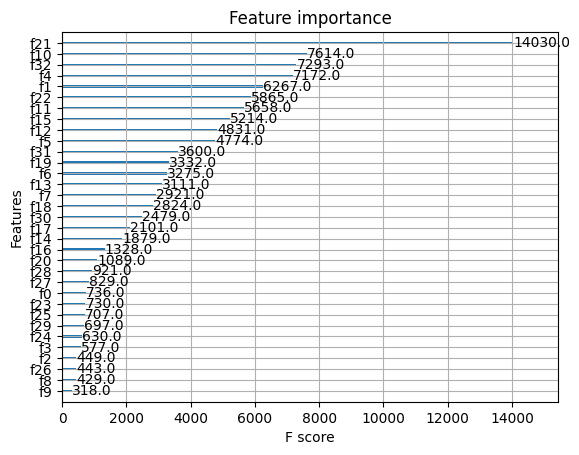

In [ ]:
# feature importance
plot_importance(xgb_model)
plt.show()

In [ ]:
# checking names for the features
encoded_feature_names = preprocessor.get_feature_names_out()

important_features_indices = list(range(0, 33))
important_features_names = [encoded_feature_names[i] for i in important_features_indices]

for i, name in zip(important_features_indices, important_features_names):
    print(f"f{i} odpowiada: {name}")

f0 odpowiada: js_encoder__product_name
f1 odpowiada: js_encoder__user_id
f2 odpowiada: targetencoder__department
f3 odpowiada: targetencoder__aisle
f4 odpowiada: remainder__num_orders
f5 odpowiada: remainder__avg_num_products
f6 odpowiada: remainder__avg_time_in_orders
f7 odpowiada: remainder__product_rank
f8 odpowiada: remainder__aisle_rank
f9 odpowiada: remainder__department_rank
f10 odpowiada: remainder__cum_days_since_prior_order
f11 odpowiada: remainder__avg_days_between_prod_orders
f12 odpowiada: remainder__ratio_product_reordered_times
f13 odpowiada: remainder__user_prod_avg_pos_cart
f14 odpowiada: remainder__user_prod_max_pos
f15 odpowiada: remainder__ratio_consecutive_reorders
f16 odpowiada: remainder__max_consecutive_reorders
f17 odpowiada: remainder__ratio_avg_time_prod_order_to_mode
f18 odpowiada: remainder__ratio_mode_to_avg_time_order
f19 odpowiada: remainder__user_product_avg_position_ratio
f20 odpowiada: remainder__added_early_prod_mean
f21 odpowiada: remainder__order_p

* Less important features are: department_rank, aisle_rank, percent of shopping during night time, targetencoded departments and aisles
* It's worth to compare these results with SHAP and evaluate if there are common variables which can have no influence on model performance

In [61]:
# getting out feature names to include them in SHAP plots
feature_names = [name.split("__")[-1] for name in preprocessor.get_feature_names_out()]

SHAP dla klasy 0


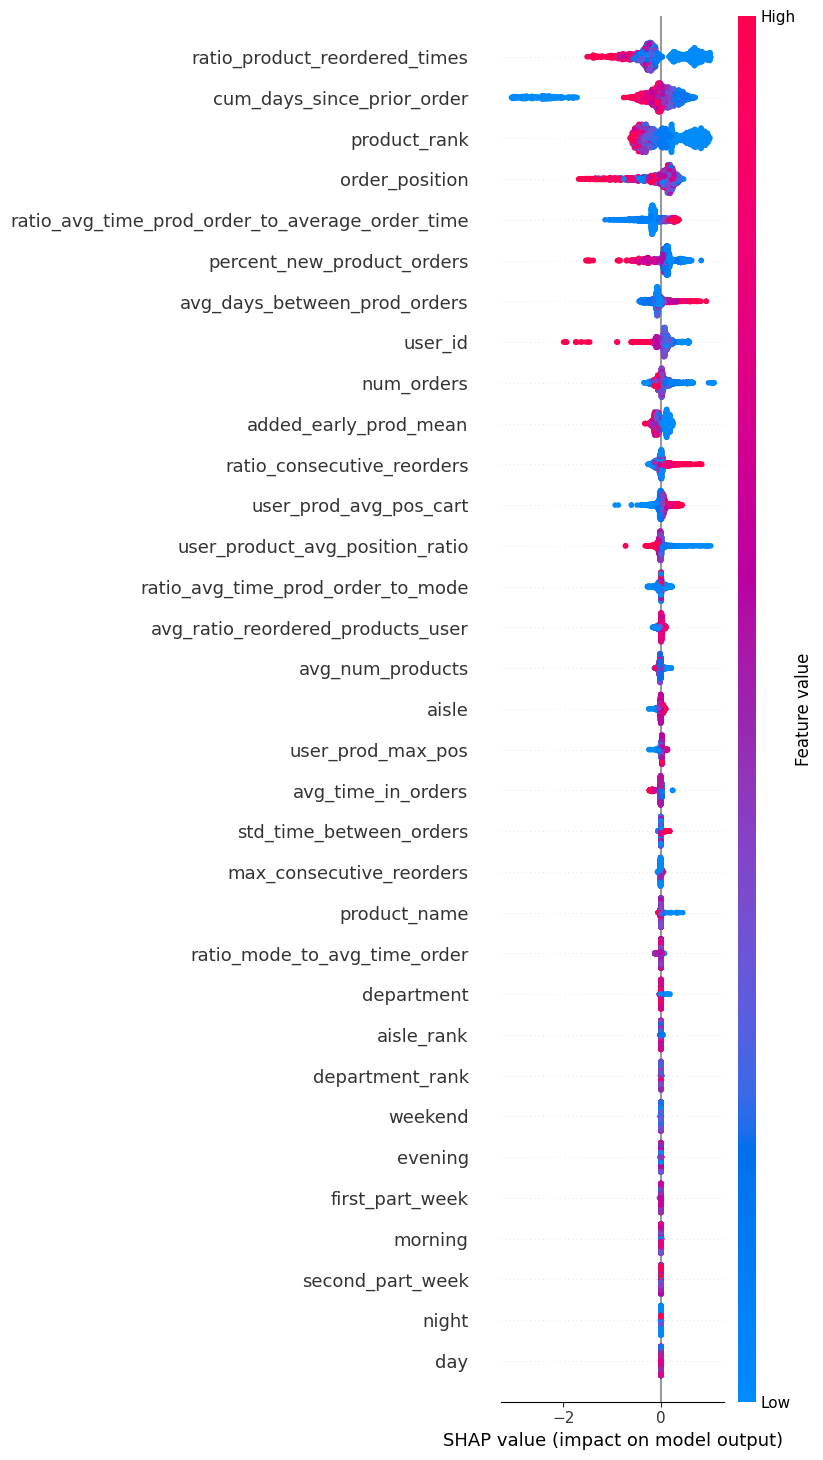

SHAP dla klasy 1


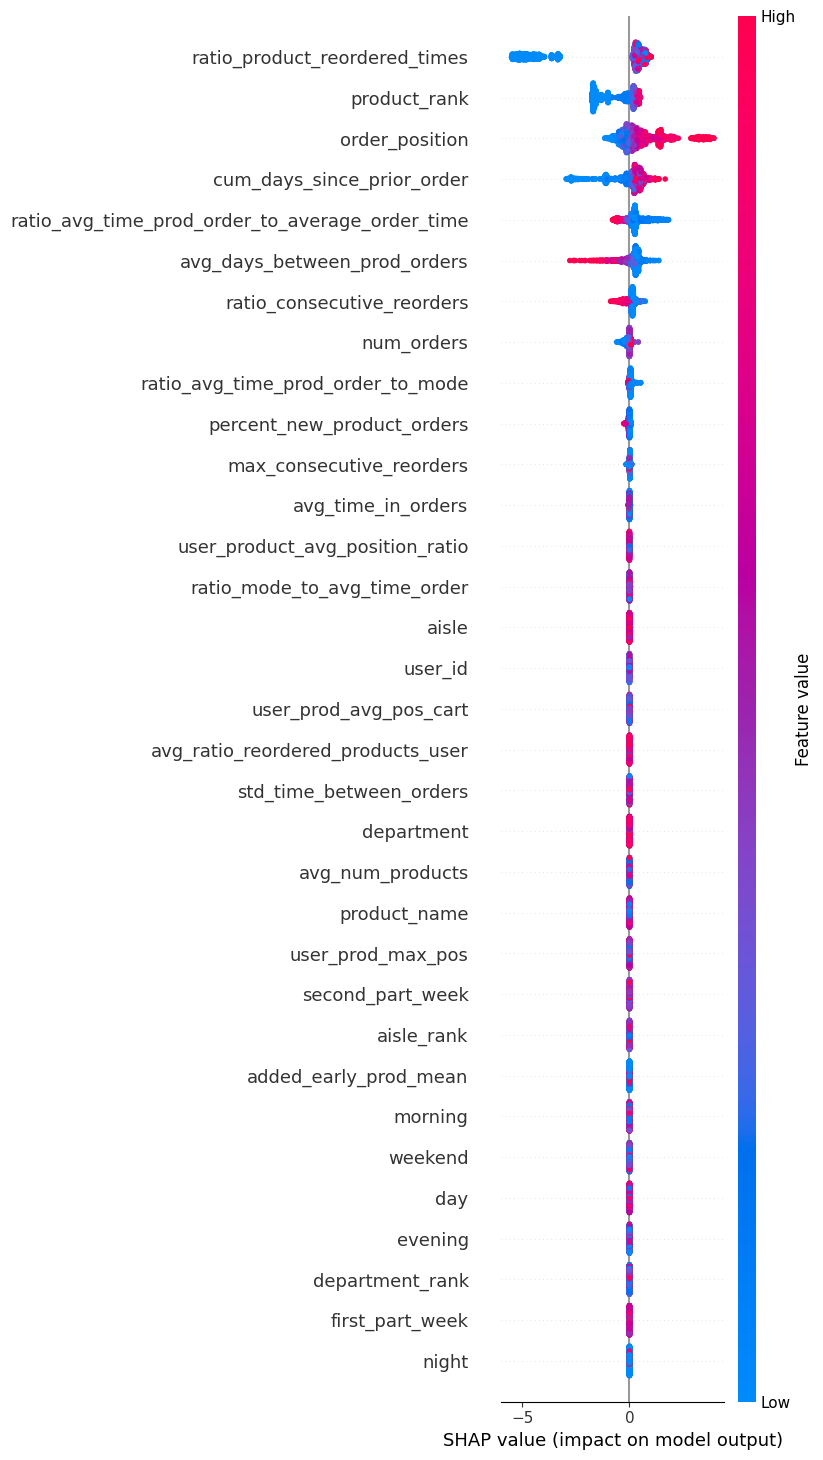

SHAP dla klasy 2


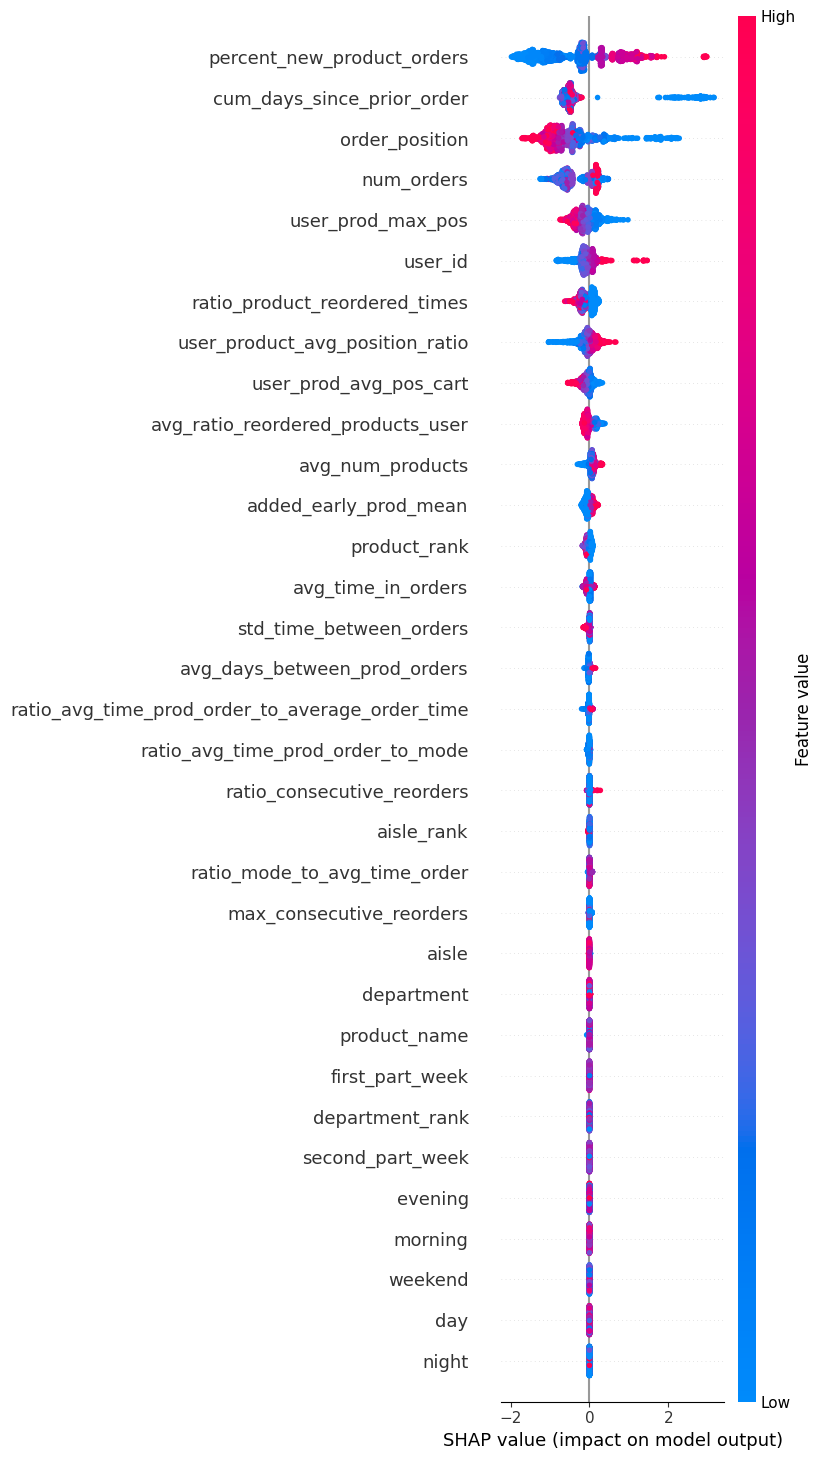

In [64]:
# using just sample of observations due to large amount of data
X_sample = X_train_transformed[-2000:]

explainer = shap.TreeExplainer(xgb_model, feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(X_sample)

X_sample_df = pd.DataFrame(X_sample, columns=feature_names)

# due to having 3 classes there is needed iteration through data to get for each summary plot
for class_idx in range(3):
    print(f"SHAP for class {class_idx}")

    shap_values_class = shap_values[:, :, class_idx]

    shap.summary_plot(shap_values_class, X_sample_df, max_display= 33)

There are common variables for all 3 classes which have no influence on predictions. They also appeared in feature importance as the less important. I am going to exclude them from data and to check the result.

In [8]:
# excluding variables
X_train_xgb_new = train_set.drop(columns = ['department', 'aisle', 'department_rank', 'aisle_rank', 'night', 'evening', 'weekend', 'morning', 'day', 'first_part_week', 'second_part_week', 'reordered'])
y_train_xgb_new = train_set['reordered']
X_test_xgb_new = test_set.drop(columns = ['department', 'aisle', 'department_rank', 'aisle_rank', 'night', 'evening', 'weekend', 'morning', 'day', 'first_part_week', 'second_part_week', 'reordered'])
y_test_xgb_new = test_set['reordered']

In [9]:
columns_lot_values_js = ['product_name', 'user_id']

preprocessor = ColumnTransformer(
    transformers= [
        ('js_encoder', JamesSteinEncoder(cols=columns_lot_values_js, model = 'independent'), columns_lot_values_js),
    ],
    remainder='passthrough')

In [10]:
# preprocessing variables
X_train_transformed_new = preprocessor.fit_transform(X_train_xgb_new, y_train_xgb_new)
X_test_transformed_new = preprocessor.transform(X_test_xgb_new)

In [78]:
# model training
xgb_model.fit(X_train_transformed_new, y_train_xgb_new, sample_weight=sample_weights)

# predictions
predictions = xgb_model.predict(X_test_transformed_new)

In [79]:
f1 = f1_score(y_test_xgb_new, predictions, average='macro')
print(f"F1-score (macro): {f1}")

F1-score (macro): 0.6150983687943594


In [80]:
print(classification_report(y_test_xgb_new, predictions))

              precision    recall  f1-score   support

           0       0.66      0.92      0.77    520420
           1       1.00      0.69      0.82    797080
           2       0.20      0.37      0.26     41431

    accuracy                           0.77   1358931
   macro avg       0.62      0.66      0.62   1358931
weighted avg       0.84      0.77      0.78   1358931



The results are almost the same as before excluding features, so it looks like good optimization especially having such amount of data.

Hyperparameter tuning. Due to the sequential nature of the data, traditional cross-validation is not possible. While it would be possible to manually divide the data for each fold, this approach would be both time-consuming and computationally expensive. For this reason, only a limited hyperparameter tuning is performed based on the train and test datasets. Additionally, the number of parameters being tested is kept small to reduce computation time, which remains significantly high.

In [15]:
# parameters for testing
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 1]
}

grid = ParameterGrid(param_grid)

best_score = 0
best_params = {}

# testing different combinations of parameters
for params in grid:

    model = xgb.XGBClassifier(
        objective='multi:softmax', eval_metric='mlogloss', random_state=42, **params
    )
    # training
    model.fit(X_train_transformed_new, y_train_xgb_new, sample_weight = sample_weights)

    # predictions
    y_pred = model.predict(X_test_transformed_new)

    # using f1 score for evaluation
    score = f1_score(y_test_xgb_new, y_pred, average='macro')

    # updating the best metrics
    if score > best_score:
        best_score = score
        best_params = params

print("Best parameters:", best_params)
print("Best F1-score result:", best_score)

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 1}
Best F1-score result: 0.6157352309749203


In [11]:
class_weights = {0: 2.0, 1: 1.0, 2: 6.0}  # assigning weights for classes
sample_weights = np.array([class_weights[label] for label in y_train_xgb_new])

In [12]:
xgb_model = XGBClassifier(n_estimators=200,
              max_depth=6,
              learning_rate=0.05,
              colsample_bytree=0.8,
              objective='multi:softprob',
              num_class=3,
              eval_metric = 'mlogloss',
              reg_alpha = 1,
              random_state=42
            )

In [13]:
# model training
xgb_model.fit(X_train_transformed_new, y_train_xgb_new, sample_weight = sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

Using probability calibration. In a three-class classification problem ensures that predicted probabilities accurately reflect the true likelihood of each class, preventing overconfidence in the dominant class and underestimation of the less frequent ones. This improves decision-making, especially when adjusting classification thresholds for cost-sensitive scenarios or when the model tends to favor one class disproportionately.

In [14]:
# extracting probabilities for all classes
y_probs = xgb_model.predict_proba(X_test_transformed_new)

# setting up tresholds based on number assigned to class vs real number of samples
optimal_threshold_0 = 0.7
optimal_threshold_1 = 0.3
optimal_threshold_2 = 0.5

# Classification based on new tresholds
y_probs[:, 0] = np.where(y_probs[:, 0] >= optimal_threshold_0, y_probs[:, 0], 0)
y_probs[:, 1] = np.where(y_probs[:, 1] >= optimal_threshold_1, y_probs[:, 1], 0)
y_probs[:, 2] = np.where(y_probs[:, 2] >= optimal_threshold_2, y_probs[:, 2], 0)

y_pred_adjusted = np.argmax(y_probs, axis=1)

print(classification_report(y_test_xgb_new, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.66      0.92      0.77    520420
           1       1.00      0.69      0.82    797080
           2       0.20      0.37      0.26     41431

    accuracy                           0.77   1358931
   macro avg       0.62      0.66      0.62   1358931
weighted avg       0.84      0.77      0.78   1358931



In [15]:
f1 = f1_score(y_test_xgb_new, y_pred_adjusted, average='macro')
print(f"F1-score (macro): {f1}")

F1-score (macro): 0.6160513218523982


In [16]:
# checking number of predicted samples in each class vs real number of samples
unique, counts = np.unique(y_pred_adjusted, return_counts=True)

print("Number of assigned prediced samples to classes:", dict(zip(unique, counts)))

unique_true, counts_true = np.unique(y_test_xgb_new, return_counts=True)
print("Real structure of classes:", dict(zip(unique_true, counts_true)))

Number of assigned prediced samples to classes: {0: 729139, 1: 552775, 2: 77017}
Real structure of classes: {0: 520420, 1: 797080, 2: 41431}


**Conclusions**
* Manual adjustment of class thresholds did not significantly improve the results.
* The biggest issue is the incorrect prediction of class 2, which is strongly related to its small sample size. Due to the sequential nature of the data, oversampling and undersampling methods are difficult to apply effectively.

**Potential next steps:**
* Generating separate binary predictions for class 2 vs. the rest and combining the results with the current XGBoost predictions.
* Further hyperparameter tuning, though this would require significant computational resources.
* Re-evaluating feature selection for class 2 to improve its classification.

### CatBoost

CatBoost is optimized for categorical data, automatically handling encoding
without the need for manual preprocessing, which saves time and improves model efficiency. It is less prone to overfitting compared to XGBoost and LightGBM, thanks to its unique Ordered Boosting algorithm, which reduces information leakage between trees. CatBoost is highly efficient for large datasets, offering fast training speed and excellent predictive performance, making it a strong alternative to other gradient boosting frameworks.

In [9]:
# preparing datasets
X_train_cat = train_set.drop(columns = ['department', 'aisle', 'department_rank', 'aisle_rank', 'night', 'evening', 'weekend', 'morning', 'day', 'first_part_week', 'second_part_week', 'reordered'])
y_train_cat = train_set['reordered']
X_test_cat = test_set.drop(columns = ['department', 'aisle', 'department_rank', 'aisle_rank', 'night', 'evening', 'weekend', 'morning', 'day', 'first_part_week', 'second_part_week', 'reordered'])
y_test_cat = test_set['reordered']

Even though CatBoost has a built-in mechanism for handling categorical variables, it does not perform well with features that have a high number of unique values, such as user_id (~130k unique values). Therefore, encoding is still necessary for these two columns: product_name and user_id.

In [10]:
columns_lot_values_js = ['product_name', 'user_id']

preprocessor = ColumnTransformer(
    transformers= [
        ('js_encoder', JamesSteinEncoder(cols=columns_lot_values_js, model = 'independent'), columns_lot_values_js)
    ],
    remainder='passthrough')

In [11]:
# since CatBoost is optimized for working with DataFrames, converting an array into a DataFrame is generally recommended
X_train_preprocessed = preprocessor.fit_transform(X_train_cat, y_train_cat)
X_test_preprocessed = preprocessor.transform(X_test_cat)

In [13]:
# getting out features names
feature_names = preprocessor.get_feature_names_out()
cleaned_feature_names = [
    name.split('__')[-1] if '__' in name else name for name in feature_names
]

In [14]:
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=cleaned_feature_names)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=cleaned_feature_names)

In [15]:
cat_model = CatBoostClassifier(
    task_type = 'CPU',
    iterations=1000,
    learning_rate=0.01,
    depth=8,
    l2_leaf_reg=5,
    loss_function='MultiClassOneVsAll',
    early_stopping_rounds=50, # to reduce training time by stopping the model when the validation performance no longer improves
    random_seed=42,
    custom_metric=['TotalF1', 'Accuracy']
)

In [16]:
class_weights = {0: 2.0, 1: 1.0, 2: 6.0}  # assigning weights for classes
sample_weights = np.array([class_weights[label] for label in y_train_cat])

In [17]:
cat_model.fit(X_train_preprocessed, y_train_cat, eval_set=(X_test_preprocessed, y_test_cat), sample_weight=sample_weights)
predictions = cat_model.predict(X_test_preprocessed)

0:	learn: 0.6860879	test: 0.6879588	best: 0.6879588 (0)	total: 5.9s	remaining: 1h 38m 10s
1:	learn: 0.6791777	test: 0.6828139	best: 0.6828139 (1)	total: 11.3s	remaining: 1h 34m 1s
2:	learn: 0.6723470	test: 0.6780450	best: 0.6780450 (2)	total: 16.9s	remaining: 1h 33m 32s
3:	learn: 0.6657179	test: 0.6727370	best: 0.6727370 (3)	total: 23.1s	remaining: 1h 35m 51s
4:	learn: 0.6592028	test: 0.6677223	best: 0.6677223 (4)	total: 29.3s	remaining: 1h 37m 17s
5:	learn: 0.6527765	test: 0.6628872	best: 0.6628872 (5)	total: 36.1s	remaining: 1h 39m 33s
6:	learn: 0.6464774	test: 0.6581192	best: 0.6581192 (6)	total: 42.7s	remaining: 1h 40m 51s
7:	learn: 0.6403060	test: 0.6543289	best: 0.6543289 (7)	total: 49.2s	remaining: 1h 41m 44s
8:	learn: 0.6342553	test: 0.6507064	best: 0.6507064 (8)	total: 55.4s	remaining: 1h 41m 44s
9:	learn: 0.6282559	test: 0.6466102	best: 0.6466102 (9)	total: 1m 1s	remaining: 1h 41m 50s
10:	learn: 0.6224109	test: 0.6423169	best: 0.6423169 (10)	total: 1m 7s	remaining: 1h 41m 21s

In [18]:
f1 = f1_score(y_test_cat, predictions, average='macro')
print(f"F1-score (macro): {f1}")

F1-score (macro): 0.6011888655091032


In [19]:
print(classification_report(y_test_cat, predictions))

              precision    recall  f1-score   support

           0       0.65      0.87      0.74    520420
           1       1.00      0.68      0.81    797080
           2       0.17      0.48      0.25     41431

    accuracy                           0.75   1358931
   macro avg       0.61      0.68      0.60   1358931
weighted avg       0.84      0.75      0.77   1358931



After making a few parameter adjustments, I achieved similar results to XGBoost (even slightly lower), but the training time was significantly longer (2.5 times longer). Additionally, I couldn’t use the built-in mechanism for categorical variables due to the high number of unique values. For these reasons, I decided not to further develop this model and to focus more on XGBoost.

### GRU - Tensorflow, Keras

GRU is a type of neural network that handles sequential data well, making it useful for tasks like time series forecasting and natural language processing. It has special mechanisms that allow it to retain important information and skip less relevant details, helping to avoid the vanishing gradient problem. Compared to LSTM, it has fewer parameters, making it faster to train while still achieving similar performance.

In [11]:
train_set_nn = train_set.copy()
test_set_nn = test_set.copy()

Feature scaling is important for GRU because it helps stabilize training, speeds up convergence, and prevents larger values from dominating the learning process.

In [12]:
# scaling the numerical features
scaler_features = ['num_orders', 'avg_num_products', 'avg_time_in_orders', 'product_rank', 'aisle_rank', 'department_rank', 'cum_days_since_prior_order',
                   'avg_days_between_prod_orders', 'user_prod_avg_pos_cart', 'user_prod_max_pos', 'max_consecutive_reorders', 'ratio_avg_time_prod_order_to_mode',
                   'ratio_mode_to_avg_time_order', 'ratio_avg_time_prod_order_to_average_order_time', 'std_time_between_orders']

scaler = MinMaxScaler()
train_set_nn[scaler_features] = scaler.fit_transform(train_set_nn[scaler_features])
test_set_nn[scaler_features] = scaler.transform(test_set_nn[scaler_features])

Embedding is recommended for GRU because it transforms categorical variables into dense vectors, allowing the model to learn meaningful relationships and capture sequential patterns more effectively.

In [85]:
# maximum number in products_id for embedding
train_set_nn['product_id'].max()

49688

In [ ]:
# maximum number in user_id for embedding
test_set_nn['user_id'].max()

206209


In [13]:
product_embedding_layer = Embedding(input_dim=49689, output_dim=16, name='product_embedding')
aisle_embedding_layer = Embedding(input_dim=135, output_dim=4, name='aisle_embedding')
user_embedding_layer = Embedding(input_dim=206210, output_dim=8, name='user_embedding')

In [14]:
# matching embeddings with product ids in train set
train_product_embeds = product_embedding_layer(train_set_nn['product_id'].values).numpy()
train_aisle_embeds = aisle_embedding_layer(train_set_nn['aisle_id'].values).numpy()
train_user_embeds = user_embedding_layer(train_set_nn['user_id'].values).numpy()

In [15]:
# matching embeddings with product ids in test set
test_product_embeds = product_embedding_layer(test_set_nn['product_id'].values).numpy()
test_aisle_embeds = aisle_embedding_layer(test_set_nn['aisle_id'].values).numpy()
test_user_embeds = user_embedding_layer(test_set_nn['user_id'].values).numpy()

In [16]:
# Adding embeddings to the main train data set
for i in range(16):
    train_set_nn[f'product_embed_{i}'] = train_product_embeds[:, i]

for i in range(4):
    train_set_nn[f'aisle_embed_{i}'] = train_aisle_embeds[:, i]

for i in range(8):
    train_set_nn[f'user_embed_{i}'] = train_user_embeds[:, i]

In [17]:
# Adding embeddings to the main test data set
for i in range(16):
    test_set_nn[f'product_embed_{i}'] = test_product_embeds[:, i]

for i in range(4):
    test_set_nn[f'aisle_embed_{i}'] = test_aisle_embeds[:, i]

for i in range(8):
    test_set_nn[f'user_embed_{i}'] = test_user_embeds[:, i]

In [18]:
# deleting embedded columns
columns_to_del = ['product_id', 'aisle_id']

In [19]:
train_set_nn.drop(columns = columns_to_del, inplace = True)
test_set_nn.drop(columns = columns_to_del, inplace = True)

In [20]:
def create_sequences(df, batch_size=20, max_products=145):
    """
    Function generates batches in appropriate shape with padding.
    Args: df, batch size and expected maximum number of products
    Returns: batch in shape (batch size = number of orders in batch, number of products, features)
    """
    # optimizing data types to improve performance
    df['user_id'] = df['user_id'].astype(np.int32)
    df['order_id'] = df['order_id'].astype(np.int32)
    df['reordered'] = df['reordered'].astype(np.int8)

    # sorting data to hold them in sequence
    df = df.sort_values(by=['user_id', 'order_position']).reset_index(drop=True)

    # grouping by user and order
    grouped = df.groupby(['user_id', 'order_id'])

    current_batch_products, current_batch_targets = [], []

    for (user_id, order_position), group in grouped:
        # converting products with its features and target column to numpy as it is more effective than using lists
        products = group.drop(columns=['user_id', 'order_id', 'reordered']).to_numpy(dtype=np.float32)
        targets = group['reordered'].to_numpy(dtype=np.int8)

        # padding for supplementing number of products to equal for all orders as it is expected by GRU
        padded_products = np.zeros((max_products, products.shape[1]), dtype=np.float32)
        padded_targets = np.zeros(max_products, dtype=np.int8)

        # filling with existing products
        length = min(len(products), max_products)
        padded_products[:length] = products[:length]
        padded_targets[:length] = targets[:length]

        current_batch_products.append(padded_products)
        current_batch_targets.append(padded_targets)

        # in case the batch is full returning batches
        if len(current_batch_products) >= batch_size:
            yield np.stack(current_batch_products, dtype=np.float32), np.expand_dims(np.stack(current_batch_targets, dtype=np.int8), axis=-1)
            current_batch_products, current_batch_targets = [], []

    # return of the last batch
    if current_batch_products:
        yield np.stack(current_batch_products, dtype=np.float32), np.expand_dims(np.stack(current_batch_targets, dtype=np.int8), axis=-1)

In [ ]:
# in case of using in each epoch all batches
def infinite_generator(df, batch_size=2000, max_products=145):
    while True:
        for batch in create_sequences(df, batch_size, max_products):
            yield batch

In [21]:
# creating generator
train_generator = create_sequences(train_set_nn)

In [22]:
# is used to force TensorFlow to execute functions eagerly instead of using graph execution, which makes debugging easier and allows for more intuitive error tracking
tf.config.run_functions_eagerly(True)

In [23]:
# GRU parameters
max_products = 145
feature_size = 58

# input layer: (batch_size = orders, max_products, feature_size)
inputs = Input(shape=(max_products, feature_size))

# masking of null values
masked = Masking(mask_value=0.0)(inputs)

# prforming GRU for orders taking into consideration single products
x = GRU(128, return_sequences=True, dropout = 0.2)(masked)

# output layer for each product's predictions and for 3 classes problem
outputs = TimeDistributed(Dense(3, activation='softmax'))(x)

# creating model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[CategoricalAccuracy()])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 145, 58)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 145, 58)        │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking (Masking)         │ (None, 145, 58)        │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any (Any)                 │ (None, 145)            │              0 │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 145, 128)       │         72,192 │ masking[0][0],         │
│                           │                        │                │ any[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 145, 3)         │            387 │ gru[0][0], any[0][0]   │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 72,579 (283.51 KB)

 Trainable params: 72,579 (283.51 KB)

 Non-trainable params: 0 (0.00 B)

This model uses a GRU layer to process order data, where each order can have up to 145 products, each described by 58 features. It applies masking to ignore missing values, then the GRU layer learns patterns in the sequence. The output layer predicts one of three possible classes for each product using a softmax activation.

In [24]:
model.fit(train_generator, epochs=10, steps_per_epoch = 100)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 412ms/step - categorical_accuracy: 0.0599 - loss: 0.9226
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - categorical_accuracy: 0.0092 - loss: 0.7425
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 405ms/step - categorical_accuracy: 0.0776 - loss: 0.6480
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - categorical_accuracy: 0.6130 - loss: 0.5768
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 405ms/step - categorical_accuracy: 0.9548 - loss: 0.5999
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 406ms/step - categorical_accuracy: 0.9590 - loss: 0.6053
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 406ms/step - categorical_accuracy: 0.9633 - loss: 0.6101
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - categorical_accuracy: 0.9565 - loss: 0.5804
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - categorical_accuracy: 0.9538 - loss: 0.5810
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - categorical_accuracy: 0.9586 - loss: 0.5745


In [26]:
model.save("model_new.keras")

I selected 10 epochs, each with the next 2k records. I also tried generating all data in each epoch, but it didn’t make a visible difference in the results. The biggest change happened when I increased the batch size. I think this is because of the data structure. Since there is no extra dimension to group orders by client, increasing the batch size weakens the connection between a client and their orders.

In [27]:
# creating batches for testing data and preparing predictions, also for limited number of oservations
test_generator = create_sequences(test_set_nn)

y_pred = model.predict(test_generator, steps = 1000)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 203s 203ms/step


In [28]:
np.save("y_pred_new.npy", y_pred)

In [29]:
y_pred_labels = np.argmax(y_pred, axis=-1)  # Choosing the label with the highest probability

In [30]:
# extracting y_test values for limited number of observations
test_generator = create_sequences(test_set_nn)

y_true_list = []
batch_limit = 1000

for i, (_, y_batch) in enumerate(test_generator):
    if i >= batch_limit:
        break
    y_true_list.append(y_batch)

y_true = np.concatenate(y_true_list)

In [31]:
real_lengths = test_set_nn.groupby(['user_id', 'order_id']).size().to_list()

In [32]:
real_lengths = real_lengths[:len(y_true)]

filtered_y_true = []
filtered_y_pred = []

for i, length in enumerate(real_lengths):
    # extracting only not padded products
    filtered_y_true.append(y_true[i, :length])
    filtered_y_pred.append(y_pred_labels[i, :length])

# reshaping to 1D list
y_true_filtered = np.concatenate(filtered_y_true)
y_pred_filtered = np.concatenate(filtered_y_pred)

In [33]:
# results
print(classification_report(y_true_filtered, y_pred_filtered))

              precision    recall  f1-score   support

           0       0.60      0.89      0.72     79150
           1       1.00      0.60      0.75    122675
           2       0.10      0.26      0.15      6314

    accuracy                           0.70    208139
   macro avg       0.57      0.59      0.54    208139
weighted avg       0.82      0.70      0.72    208139



* These results are based on only 20k samples, which is likely one of the reasons for the current model performance.
* With such a large dataset, it is computationally expensive to process all the data.
* I did not use the full dataset because the structure was not optimal—sequences were represented by products, and the batch size had to remain small to preserve the order of a client’s purchases. Increasing the batch size led to worse results.
* These results confirm the findings from previous models—the biggest issue remains the underrepresented class 2.

**Next steps**
* Develop a data generator where the batch size is defined by the number of clients, followed by their orders, preserving temporal dependencies. This is computationally expensive as padding must be applied at two levels: orders and products.
* Design a model structure that considers order sequences during predictions but produces results at the product level.
* I have started implementing the above approach, but due to computational constraints, further testing was not possible.

In [ ]:
# generator for 4-dimensional data
def create_sequences_user(df, batch_size=20, max_products=145, max_orders_per_user=98):
    """
    Function generates batches in appropriate shape with padding.
    Args: df, batch size, expected maximum number of products, expected maximum number of orders
    Returns: batch in shape (batch size = number of users in batch, number of orders, number of products, features)
    """
    df['user_id'] = df['user_id'].astype(np.int32)
    df['order_id'] = df['order_id'].astype(np.int32)
    df['reordered'] = df['reordered'].astype(np.int8)

    df = df.sort_values(by=['user_id', 'order_position']).reset_index(drop=True)

    grouped = df.groupby('user_id')

    current_batch_products, current_batch_targets = [], []
    batch_users = 0

    for user_id, user_group in grouped:
        user_orders = user_group.groupby('order_id')

        user_products, user_targets = [], []

        for order_id, order_group in user_orders:
            products = order_group.drop(columns=['user_id', 'order_id', 'reordered']).to_numpy(dtype=np.float32)
            targets = order_group['reordered'].to_numpy(dtype=np.int8)

            # padding for products
            padded_products = np.zeros((max_products, products.shape[1]), dtype=np.float32)
            padded_targets = np.zeros(max_products, dtype=np.int8)

            length = min(len(products), max_products)
            padded_products[:length] = products[:length]
            padded_targets[:length] = targets[:length]

            user_products.append(padded_products)
            user_targets.append(padded_targets)

        # padding for orders
        num_orders = len(user_products)
        padded_orders = np.zeros((max_orders_per_user, max_products, products.shape[1]), dtype=np.float32)
        padded_order_targets = np.zeros((max_orders_per_user, max_products), dtype=np.int8)

        length = min(num_orders, max_orders_per_user)
        padded_orders[:length] = np.array(user_products[:length])
        padded_order_targets[:length] = np.array(user_targets[:length])

        current_batch_products.append(padded_orders)
        current_batch_targets.append(padded_order_targets)
        batch_users += 1

        if batch_users >= batch_size:
            yield np.array(current_batch_products, dtype=np.float32), np.expand_dims(np.array(current_batch_targets, dtype=np.int8), axis=-1)
            current_batch_products, current_batch_targets = [], []
            batch_users = 0

    if current_batch_products:
        yield np.array(current_batch_products, dtype=np.float32), np.expand_dims(np.array(current_batch_targets, dtype=np.int8), axis=-1)

## **Conclusions**

* The best results were achieved with XGBoost, which is why I focused on developing this model through hyperparameter tuning, feature selection, and handling class imbalances.
* The model performed well for classes 0 and 1, achieving high F1-scores (0.77 and 0.82), meaning it effectively balances precision and recall. However, class 2 remains a challenge, with an F1-score of only 0.26, likely due to its low representation in the dataset, making it harder for the model to differentiate it from other classes.
* I focused on F1-score because the dataset is imbalanced, and accuracy alone would not properly reflect the model’s performance.
* The next steps include testing whether a GRU-based model could outperform XGBoost. If not, I would continue improving XGBoost with additional feature selection, hyperparameter tuning, and potentially a separate model for class 2.
* After these optimizations, the final model would be evaluated on the test set, which has not been used yet. So far, I have worked with the training set split into training and validation data.
* Improving reorder predictions can help businesses optimize inventory management, reduce stock shortages, and enhance customer satisfaction through better product recommendations.
* There are also key challenges in this project, such as the large dataset (~20.5 million observations), high feature complexity, and the risk of data leakage.

## **Model Related Answers**

**Why do you select this problem for the ML project?**

I selected this topic because e-commerce is a field I am very familiar with, and I have domain knowledge in this segment. Additionally, predicting product reorders is a critical problem for optimizing inventory management, enhancing customer experience, and increasing sales efficiency. This makes the problem not only interesting but also highly relevant in real-world applications.

**How can your models be applied in real-life?**

Understanding which products are likely to be reordered allows businesses to improve demand forecasting, reduce stockouts, and personalize recommendations.

**Why do you choose a specific algorithm?**

I chose following models:
* Logistic Regression - I wanted to establish a baseline, even though I knew it wasn’t the best choice for this problem.
* Random Forest - a good choice for capturing non-linear dependencies and robust to variable ranges.
* XGBoost - more efficient for handling large datasets with high complexity.
* CatBoost - includes built-in mechanisms for categorical variables, but in my case, they were ineffective due to the large number of unique values.
* GRU - I saw great potential in capturing sequential dependencies, which turned out to be crucial in my dataset.

**What feature engineering have you done to improve the model performance?**

* I created more general features that could be used without causing data leakage.
* I added features that capture order patterns, such as time between reorders, how often a product is bought, and changes in order size.
* I transformed categorical features into numerical values to handle a large number of unique products and users.
* I used scaling where needed to help models like GRU learn better.

**How can you further improve your model?**

With more computing power, I would start by testing different GRU model structures to see if they can outperform XGBoost. If GRU does not show better results, I would go back and focus on further hyperparameter tuning for XGBoost. Finally, I would build a separate model specifically for predicting class 2 vs. the rest and combine its results with XGBoost using a weighted approach.